In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline
import warnings
import re
warnings.filterwarnings('ignore')

In [3]:
import random
random.seed(666)

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [33]:
file_path = r"C:\Users\17366\OneDrive - Queen's University\Queen's\Comm 461\Project\bgg_boardgames_top_2000.feather"
top_game = pd.read_feather(file_path)

In [7]:
top_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   boardgame_id          1999 non-null   int32  
 1   title                 1999 non-null   object 
 2   year_published        1999 non-null   Int16  
 3   minplayers            1999 non-null   Int8   
 4   maxplayers            1999 non-null   Int16  
 5   minplaytime           1999 non-null   Int32  
 6   maxplaytime           1999 non-null   Int32  
 7   age                   1999 non-null   Int16  
 8   users_rated           1999 non-null   Int32  
 9   average_rating        1999 non-null   float32
 10  bayes_average_rating  1999 non-null   float32
 11  median                1999 non-null   float32
 12  stddev                1999 non-null   float32
 13  owned                 1999 non-null   Int32  
 14  trading               1999 non-null   Int16  
 15  wishing              

# Preprocessing

Create a column $demand = $owned + $trading + $wishing. We assume that the total number of owned, trading, and wishing would be a indicator of a board games general demand.

In [8]:
top_game['demand'] = top_game['owned'] + top_game['trading'] + top_game['wishing']

In [9]:
top_game.drop(['owned', 'trading', 'wishing'], axis=1, inplace=True)

<Axes: >

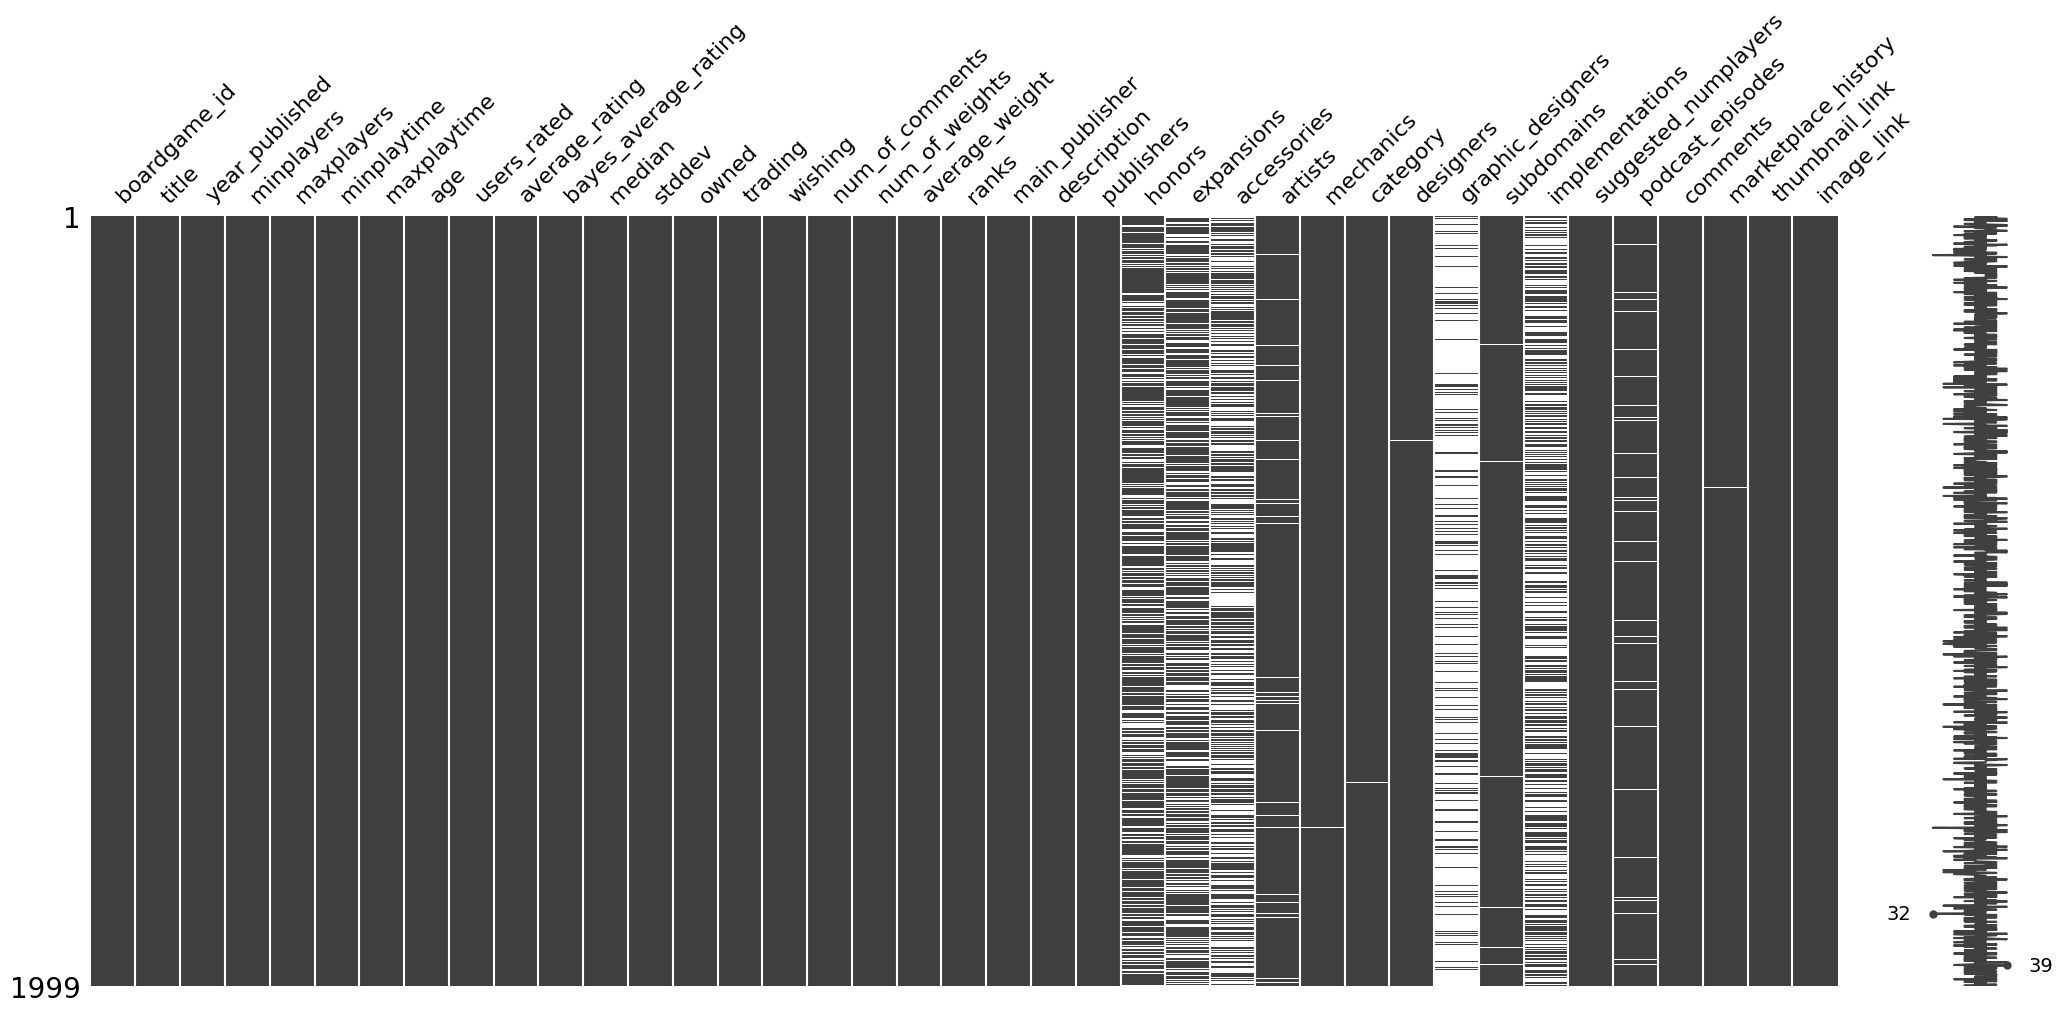

In [34]:
msno.matrix(top_game)

## Drop excluded columns

1. Drop columns that contain links to BGG/external websites

In [10]:
top_game = top_game.drop(['podcast_episodes', 'marketplace_history', 'thumbnail_link', 'image_link', 'implementations'], axis=1)

2. Drop suggested_players, which we believe is an unsorted data that is not informative. We would analyze demand based on minplayer/maxplayer.

In [11]:
top_game = top_game.drop(['suggested_numplayers'], axis=1)

3. Drop median. Every row in median column is 0. We believe this is an error in the original data set

In [12]:
top_game = top_game.drop(['median'], axis=1)

4. Drop num_of_comments, num_of_weights, average_weight. These three columns contains information regarding the number of comments, as well as the number of comments that are used toward rating calculation. As the aim of the analysis is to predict demand for unpublished new board games, we do not have comments data. Thus, we decide to drop these columns from our training sample. We decide to drop user_rated and honors column as they are not applicable to new games as well.

In [13]:
top_game.drop(['num_of_comments', 'num_of_weights', 'average_weight', 'users_rated', 'honors'], axis=1, inplace=True)


## Preliminary Feature Engineering

1. Change expansions and accessories column – count number of expansions and accessories

In [14]:
#create the function that count the number of expansion/accessories. As the data set split each expansion/accessory with "|", 
# we only need to count the number of "|", and the number of expansion/accessory equals to number of "|" + 1

def counter(column, column_new):
    top_game[column_new] = top_game[column].str.count("\\|") + 1
    top_game[column_new].fillna(0, inplace=True)

counter("expansions", "expansions_count")
counter("accessories", "accessories_count")

In [15]:
top_game.drop(['expansions', 'accessories'], axis=1, inplace=True)

2. Split ranks into two columns, overall_rank and subdomain_rank

In [16]:
# Function to extract overall rank
def extract_overall_rank(x):
    match = re.search('(?<=Board Game Rank\\|)\\d+', str(x))
    return int(match.group()) if match else 0

# Function to extract subdomain rank
def extract_subdomain_rank(x):
    match = re.search('(?<=\\|\\|)[a-zA-Z ]+ Rank\\|(\\d+)', str(x))
    return int(match.group(1)) if match else 0

# Apply the functions to the 'ranks' column to create new columns
top_game["overall_rank"] = top_game["ranks"].apply(extract_overall_rank)
top_game["subdomain_rank"] = top_game["ranks"].apply(extract_subdomain_rank)

# Handle NAs
# top_game.loc[pd.isnull(top_game["ranks"]) | (top_game["ranks"] == ""), "overall_rank"] = 0
# top_game.loc[pd.isnull(top_game["ranks"]) | (top_game["ranks"] == ""), "subdomain_rank"] = 0

In [17]:
top_game.drop(['ranks'], axis=1, inplace=True)

3. Split mechanics into two columns, mechanics_1 and mechanics_2, store the first and secondary mechanics respectively. Note that some games have mechanics of more than two; however, due to the limited number of observations in the data set, we decide to focus only on the first and secondary mechanics to reduce the number of independent variables in the model, which is sufficient to conclude the characteristics of the game.

In [18]:
def spliter(column):
    top_game[column + "_1"] = top_game[column].apply(lambda x: re.search('(?<=^)[^|/]+', x).group() if pd.notnull(x) and x != "" and re.search('(?<=^)[^|/]+', x) is not None else 0)
    top_game[column + "_2"] = top_game[column].apply(lambda x: re.search('(?<=\\|)[^|/]+(?=\\|)', x).group() if pd.notnull(x) and x != "" and re.search('(?<=\\|)[^|/]+(?=\\|)', x) is not None else 0)

spliter("mechanics")

In [19]:
top_game.drop(['mechanics'], axis=1, inplace=True)

4. Take the similar approach for category, artists, designers and graphic designers

In [20]:
spliter("category")
spliter("artists")
spliter("designers")
spliter("graphic_designers")

In [21]:
top_game.drop(['category', 'artists', 'designers', 'graphic_designers'], axis=1, inplace=True)

5. As most games do not have a secondary subdomain, we only extract the first subdomain

In [22]:
top_game["subdomains_1"] = top_game["subdomains"].apply(lambda x: re.search('(?<=^)[^|/]+', x)[0] if pd.notnull(x) and x != "" else 0)

In [23]:
top_game.drop(['subdomains'], axis=1, inplace=True)

6. Keep main publisher, and record the number of publishers

In [24]:
top_game['publisher_num'] = top_game['publishers'].str.count('|') + 1

In [25]:
top_game.drop(['publishers'], axis=1, inplace=True)

7. Formatting comments

In [26]:
top_game['comments'][0]

'0 1 1 2 3 5 8|Recommended by Joel D., Chris S., the Solo Players Group and Jason L. ||0122lostchild2201|It is a punishing game that keeps you on edge, and unlike every other LCG, you can\'t really be "behind".  What I mean by that is, you don\'t have to drop a ton of money to catch up.  You can buy the scenarios you want to play, or the expansions that have the cards you want to build the deck you want and move at your own pace because you\'re not playing against someone in a competitive setting.  Artwork is stunning and solo and cooperative play offer their own challenges and good times.||0time|If your reading the comments section cause ur thinking about buying the game, stop here, and go buy it.  It\'s pretty awesome.||100pcBlade|Initial thoughts are the scenarios (even the easy one) are way too hard for the pre-built decks in the box. This may be fine for the deck-builders who are happy to customs but the the likes of me who has little interest in this,or just a casual gamer, it ma

In [27]:
top_game['comments'] = top_game['comments'].str.replace('\|\|.*?\|', '|', regex=True)
top_game['comments'] = top_game['comments'].str.replace('^.*?\|', '', regex=True)

In [28]:
top_game['comments'][0]

'Recommended by Joel D., Chris S., the Solo Players Group and Jason L. |It is a punishing game that keeps you on edge, and unlike every other LCG, you can\'t really be "behind".  What I mean by that is, you don\'t have to drop a ton of money to catch up.  You can buy the scenarios you want to play, or the expansions that have the cards you want to build the deck you want and move at your own pace because you\'re not playing against someone in a competitive setting.  Artwork is stunning and solo and cooperative play offer their own challenges and good times.|If your reading the comments section cause ur thinking about buying the game, stop here, and go buy it.  It\'s pretty awesome.|Initial thoughts are the scenarios (even the easy one) are way too hard for the pre-built decks in the box. This may be fine for the deck-builders who are happy to customs but the the likes of me who has little interest in this,or just a casual gamer, it make shte gme almost worthless. I\'ll persevere a whil

Standardize datatypes

In [29]:
# Convert int16 or int32 columns to int64
int_columns = top_game.select_dtypes(include=['int16', 'int32','int8']).columns
top_game[int_columns] = top_game[int_columns].astype('int64')

# Convert float32 columns to float64
float_columns = top_game.select_dtypes(include=['float32']).columns
top_game[float_columns] = top_game[float_columns].astype('float64')


<Axes: >

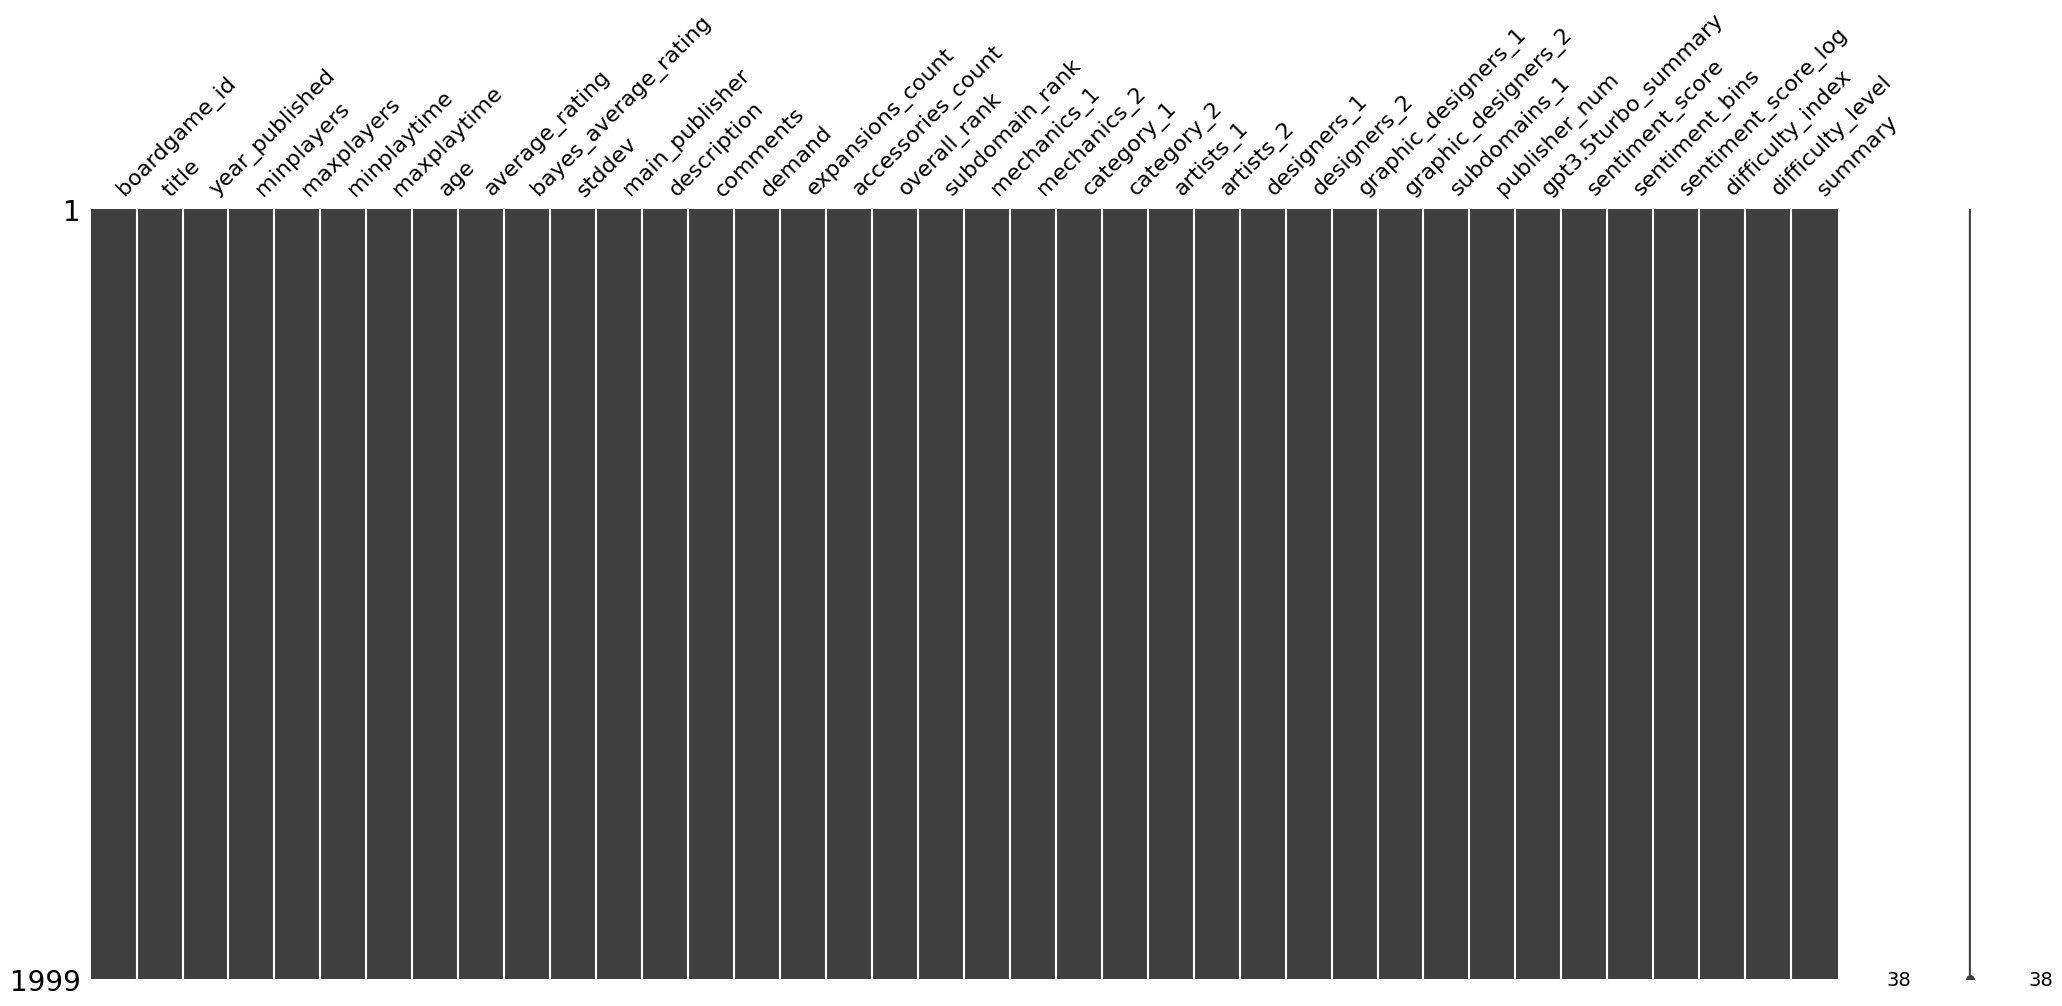

In [32]:
msno.matrix(top_game_complete)

# Baseline GBM

In [39]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define independent and target variables
independent_vars = ["age","minplayers","maxplayers","minplaytime","maxplaytime","overall_rank","subdomain_rank","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","year_published","average_rating","bayes_average_rating","stddev","main_publisher","publisher_num","expansions_count","accessories_count"]
target_var = 'demand_normalized'

# Split the data into training, validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(top_game_complete[independent_vars], top_game_complete[target_var], test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Specify the categorical columns
cat_features = ["mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","main_publisher"]

# best results:
best_params= {'use_best_model': True, 'random_strength': 2, 'iterations': 8000, 'bagging_temperature': 0, 'l2_leaf_reg': 3, 
              'grow_policy': 'SymmetricTree', 'depth': 3, 'learning_rate': 0.05, 'border_count': 254}

# Train the model with the best parameters
model = CatBoostRegressor(**best_params, loss_function='RMSE', verbose=False)
model.fit(Pool(X_train, y_train, cat_features=cat_features), eval_set=Pool(X_val, y_val, cat_features=cat_features))

# Get predictions
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Reshape the arrays
y_test = y_test.to_numpy().reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)
y_train = y_train.to_numpy().reshape(-1, 1)
y_train_pred = y_train_pred.reshape(-1, 1)

# Inverse transform
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)
y_train = scaler.inverse_transform(y_train)
y_train_pred = scaler.inverse_transform(y_train_pred)

# Evaluate the model
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f'Root Mean Squared Error on training: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_train, y_train_pred)
print(f'Mean Absolute Error on training: {mae}')

# Calculate R-squared
r2_train = r2_score(y_train, y_train_pred)
print(f'R-squared on training: {r2_train}')

n = len(y_test)  # number of samples
p = len(independent_vars)  # number of predictors

adjusted_r2_train = 1 - (1 - r2_train) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared on training: {adjusted_r2_train}')

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error on testing: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error on testing: {mae}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared on testing: {r2}')

# Calculate Adjusted R-squared
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared on testing: {adjusted_r2}')

Root Mean Squared Error on training: 1985.3278321892376
Mean Absolute Error on training: 1251.7098873961788
R-squared on training: 0.9886660020071882
Adjusted R-squared on training: 0.9869626265863032
Root Mean Squared Error on testing: 6296.166691882521
Mean Absolute Error on testing: 3269.8786667604204
R-squared on testing: 0.901653388948353
Adjusted R-squared on testing: 0.8868729734145795


In [31]:
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder

# Initialize LGBMRegressor
model = LGBMRegressor(n_estimators=100, num_leaves=31, learning_rate=0.1)

# LightGBM requires categorical features to be encoded
le = LabelEncoder()

for col in cat_features:
    combined = pd.concat([X_train[col], X_test[col]]).astype(str)  # Convert to strings
    le.fit(combined)  # Fit on combined train and test sets
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

# Fit model
model.fit(X_train, y_train, categorical_feature=cat_features)

# Get predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Calculate Adjusted R-squared
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared: {adjusted_r2}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2248
[LightGBM] [Info] Number of data points in the train set: 1599, number of used features: 25
[LightGBM] [Info] Start training from score 13698.332708
Root Mean Squared Error: 9742.220070253532
R-squared: 0.7745551118718738
Adjusted R-squared: 0.7594852664087637


  File "c:\Users\17366\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=1000, max_depth=5, random_state=0)

# Fit model
model_rf.fit(X_train, y_train)

# Get predictions
y_pred_rf = model_rf.predict(X_test)

# Evaluate the model
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print(f'Root Mean Squared Error (Random Forest): {rmse_rf}')

# Calculate R-squared
r2_rf = r2_score(y_test, y_pred_rf)
print(f'R-squared (Random Forest): {r2_rf}')

# Calculate Adjusted R-squared
n, p = X_test.shape
adjusted_r2_rf = 1 - (1 - r2_rf) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared (Random Forest): {adjusted_r2_rf}')

Root Mean Squared Error (Random Forest): 10625.913856391137
R-squared (Random Forest): 0.7318010320355652
Adjusted R-squared (Random Forest): 0.7138732935352687


# NLP Analysis of Comments

In [33]:
top_game_enhanced = top_game.copy()

In [69]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('T5-small')

# Tokenize the comments
tokens = []
for comment in top_game_enhanced['comments'][0]:
    tokens.extend(tokenizer.tokenize(comment))

# Calculate the total number of tokens
total_tokens = len(tokens)

# Print the result
print(f"Total number of tokens: {total_tokens}")


Total number of tokens: 39693


## Comment Stats

In [53]:
max_word_count = 0
max_word_comment = ""
total_comments = 0
total_word_count = 0  # Variable to keep track of the total word count

# Get the first entry of comments
comments_entry = top_game['comments'][0]

# Split the comments
comments = comments_entry.split('|')

# Process each comment
for comment in comments:

    # Remove '\n' characters and excess whitespace
    comment = comment.replace('\n', ' ').replace('\\', '').strip()

    # Count the words in the comment
    word_count = len(comment.split())

    # Update the total word count
    total_word_count += word_count

    # Update the maximum word count and the corresponding comment
    if word_count > max_word_count:
        max_word_count = word_count
        max_word_comment = comment

    # Increment the total comments count
    total_comments += 1

# Print the comment with the maximum word count, the total word count, and the total comments count
print(f"Comment with largest word count: {max_word_comment}")
print(f"Total word count: {total_word_count}")
print(f"Total comments: {total_comments}")

Comment with largest word count: The biggest thing that surprised me about this game is how thematic it is. I was simply expecting a cool card game with pretty cards. Not only did I get that, but the missions, the choices you have, the cards, and the card effect all make so much sense thematically. If you are a Tolkien fan you will NOT be disappointed. The game takes you (and you band of heroes that you can choose) on a journey within Middle Earth with varying tasks, enemies, and locations to explore.   Another thing that surprised me was how great of a Solo game this is. Not too take away from the co-op aspect of this game - it is definitely one of the best - if not the best - 2 player (co-op) game I've played. But its by far the best solo-player game I've played (admittedly I haven't played very many, but I guess that's because I never appealed to me in the first place.)  If you've been researching this game, no doubt you've heard about plethora of expansion packs and something calle

## Device Setup

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import random
from tqdm import tqdm
import pandas as pd

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(666)

# Specify the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

c:\Users\17366\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from torch.utils.data import Dataset, DataLoader

class CommentDataset(Dataset):
    def __init__(self, comments, tokenizer, max_length):
        self.comments = comments
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.comments[idx],
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

## Summarization

In [ ]:
top_game_enhanced['comments'][0]

GPTNEO

In [ ]:
from transformers import GPT2Tokenizer, GPTNeoForCausalLM

# Specify the model
model_name = "EleutherAI/gpt-neo-1.3B"

# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained(model_name, padding_side='left')

# Set the padding token
tokenizer.pad_token = tokenizer.eos_token

model = GPTNeoForCausalLM.from_pretrained(model_name)

# Move the model to the device
model = model.to(device)

# Initialize list to hold comment summaries for each entry in comments
comment_summaries = []

# Process each entry in comments
for comments_entry in tqdm(top_game['comments'][:1]):

    # Split the comments
    comments = comments_entry.split('|')

    # Initialize list to hold summaries for the current entry
    entry_summaries = []

    # Process each comment
    for comment in comments:
        # Remove '\n' characters and excess whitespace
        comment = comment.replace('\n', ' ').strip()

        # Skip empty comments
        if not comment:
            continue

        # Prepare the prompt
        prompt = f"Summarize: {comment}"

        # Tokenize the prompt and truncate to 512 tokens
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512, padding='max_length')

        # Move the inputs to the device
        inputs = inputs.to(device)

        # Get model's output
        outputs = model.generate(inputs['input_ids'], 
                         attention_mask=inputs['attention_mask'], 
                         pad_token_id=tokenizer.eos_token_id, 
                         max_new_tokens=256, 
                         num_beams=5, 
                         early_stopping=True, 
                         temperature=0.7, 
                         repetition_penalty=2.0, 
                         top_k=50, 
                         top_p=0.95)
        
        # Decode the output and append to entry_summaries
        summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
        entry_summaries.append(summary)

print(entry_summaries)

## Summarization

Google Pegasus

In [99]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

# Specify the model
model_name = "google/pegasus-large"

# Initialize tokenizer and model
tokenizer = PegasusTokenizer.from_pretrained(model_name)

model = PegasusForConditionalGeneration.from_pretrained(model_name)

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize list to hold comment summaries for each entry in comments
comment_summaries = []

# Process each entry in comments
for comments_entry in tqdm(top_game['comments'][:1]):

    # Split the comments
    comments = comments_entry.split('|')

    # Initialize list to hold summaries for the current entry
    entry_summaries = []

    # Process each comment
    for comment in tqdm(comments[:10]):

        # Remove '\n' characters and excess whitespace
        comment = comment.replace('\n', ' ').replace('\\', '').strip()

        # Skip empty comments
        if not comment:
            continue

        # Prepare the prompt
        prompt = f"{comment}"

        # Tokenize the prompt and truncate to 1024 tokens
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512, padding='max_length')

        # Move the inputs to the device
        inputs = inputs.to(device)

        # Get model's output
        outputs = model.generate(inputs['input_ids'], 
                         attention_mask=inputs['attention_mask'], 
                         max_length=150, 
                         num_beams=5, 
                         early_stopping=True)
        
        # Decode the output and append to entry_summaries
        summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
        entry_summaries.append(summary)

    # Join all summaries for the current entry with '|'
    entry_summaries_str = '|'.join(entry_summaries)

    # Append entry_summaries_str to comment_summaries
    comment_summaries.append(entry_summaries_str)

# Iterate over the list and print each summary
for summaries in comment_summaries:
    for summary in summaries.split('|'):
        print(summary)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/1 [01:05<?, ?it/s]


KeyboardInterrupt: 

Google T5

In [98]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Specify the model
model_name = "t5-large"

# Initialize tokenizer and model
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize list to hold comment summaries for each entry in comments
comment_summaries = []

# Initialize a TfidfVectorizer
vectorizer = TfidfVectorizer()

# Process each entry in comments
for comments_entry in tqdm(top_game['comments'][:1]):

    count = 0
    
    # Split the comments
    comments = comments_entry.split('|')

    # Initialize list to hold summaries for the current entry
    entry_summaries = []

    # Process each comment
    for comment in tqdm(comments[:10]):
        # Remove '\n' characters and excess whitespace
        comment = comment.replace('\n', ' ').replace('\\', '').strip()

        # Skip empty comments
        if not comment:
            continue

        # Prepare the prompt
        prompt = f"summarize: {comment}"

        # Tokenize the prompt and truncate to 512 tokens
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512, padding='max_length')

        # Move the inputs to the device
        inputs = inputs.to(device)

        # Get model's output
        outputs = model.generate(inputs['input_ids'], 
                         attention_mask=inputs['attention_mask'], 
                         max_length=150, 
                         num_beams=5,
                         top_k=40, 
                         early_stopping=True)
        
        # Decode the output and append to entry_summaries
        summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
        entry_summaries.append(summary)

    # # Compute tf-idf vectors for the summaries
    # tfidf_matrix = vectorizer.fit_transform(entry_summaries)

    # # Compute cosine similarity between all pairs of summaries
    # cosine_sim = cosine_similarity(tfidf_matrix)

    # # For each pair of summaries, if the similarity is above a threshold, remove one of them
    # threshold = 0.8
    # for i in range(len(entry_summaries)):
    #     for j in range(i+1, len(entry_summaries)):
    #         if cosine_sim[i, j] > threshold:
    #             entry_summaries[j] = ""
    #             count += 1

    # Join all summaries for the current entry with '|'
    entry_summaries_str = '|'.join(entry_summaries)

    # Append entry_summaries_str to comment_summaries
    comment_summaries.append(entry_summaries_str)

# Iterate over the list and print each summary
for summaries in comment_summaries:
    for summary in summaries.split('|'):
        print(summary)

# print(count)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
  0%|          | 0/1 [02:06<?, ?it/s]


KeyboardInterrupt: 

OPEN AI GPT-3.5 Turbo

In [75]:
import openai
import os
from tqdm import tqdm

client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "your-api-key"))

# Initialize list to hold comment summaries for each entry in comments
comment_summaries = []

# Process each entry in comments
for comments_entry in tqdm(top_game_enhanced['comments']):

    # Split the comments
    # comments = comments_entry.split('|')

    # Initialize list to hold summaries for the current entry
    entry_summaries = []

    # # Process each comment
    # for comment in tqdm(comments):
    #     # Remove '\n' characters and excess whitespace
    #     comment = comment.replace('\n', ' ').replace('\\', '').strip()

    #     # Skip empty comments
    #     if not comment:
    #         continue

    # Use the OpenAI API to generate a summary
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a efficient summarizer. You will summarize the boardgame comments i give to you."},
            {"role": "user", "content": comments_entry}
        ],
        max_tokens=100,
        temperature=0.2
    )

    # Convert the response to a string and append it to entry_summaries
    entry_summaries.append(str(response.choices[0].message.content))

    # Join all summaries for the current entry with '|'
    entry_summaries_str = '|'.join(entry_summaries)

    # Append entry_summaries_str to comment_summaries
    comment_summaries.append(entry_summaries_str)

# Iterate over the list and print each summary
# for summaries in comment_summaries:
#     for summary in summaries.split('|'):
#         print(summary)# 
top_game_enhanced['gpt3.5turbo_summary'] = comment_summaries

  0%|          | 0/1999 [00:00<?, ?it/s]100%|██████████| 1999/1999 [2:30:43<00:00,  4.52s/it]  


In [78]:
top_game_enhanced.to_csv('top_game_enhanced.csv', index=False)

In [80]:
import pandas as pd

top_game_updated = pd.read_csv('top_game_enhanced.csv')
top_game_updated.head()

,boardgame_id,title,year_published,minplayers,maxplayers,minplaytime,maxplaytime,age,average_rating,bayes_average_rating,stddev,main_publisher,description,comments,demand,expansions_count,accessories_count,overall_rank,subdomain_rank,mechanics_1,mechanics_2,category_1,category_2,artists_1,artists_2,designers_1,designers_2,graphic_designers_1,graphic_designers_2,subdomains_1,publisher_num,gpt3.5turbo_summary
0,77423,The Lord of the Rings: The Card Game,2011,1,2,30,60,13,7.66006,7.40469,1.55163,Fantasy Flight Games,The Lord of the Rings: The Card Game is a coop...,"Recommended by Joel D., Chris S., the Solo Pla...",40613,147.0,5.0,148,7,Cooperative Game,Deck Construction,Adventure,Card Game,Even Mehl Amundsen,Erfian Asafat,Nate French,0,0,0,Customizable Games,156,The Lord of the Rings Living Card Game (LCG) i...
1,88,Torres,1999,2,4,60,60,12,7.09677,6.79711,1.28220,F.X. Schmid,Torres is an abstract game of resource managem...,One play. Didn't do it for me at all.|Like it....,15446,0.0,0.0,643,33,Action Points,Enclosure,Abstract Strategy,0,Alessandra Cimatoribus,Michael Menzel,Michael Kiesling,0,Sabine Kondirolli,0,Abstract Games,127,"Overall, opinions on the board game Torres are..."
2,203420,Exit: The Game – The Abandoned Cabin,2016,1,6,60,120,12,7.45508,7.14742,1.32656,KOSMOS,Everyone meant to use the cabin only as a shel...,Not actually a game. More of an activity. A pl...,16612,0.0,1.0,295,70,Cooperative Game,0,Deduction,Puzzle,Silvia Christoph,Michaela Kienle,Inka Brand,0,0,0,Family Games,201,The comments provided are about the board game...
3,310448,Zombie Teenz Evolution,2020,2,4,15,25,8,7.78381,6.40919,1.28076,Le Scorpion Masqué,Zombies are attacking the entire town! Coopera...,"Jackson’s|I went into this, as an adult, with ...",4040,0.0,0.0,1334,302,Action Points,Cooperative Game,Children's Game,0,Nikao,0,Annick Lobet,0,0,0,Family Games,148,"Overall, players have found Zombie Teenz Evolu..."
4,25417,BattleLore,2006,2,2,60,60,10,7.35379,6.97599,1.42233,Days of Wonder,This game is based upon Richard Borg's Command...,Rating based on 3 plays of the most basic 2 ba...,13342,16.0,1.0,449,107,Area Majority,Command Cards,Fantasy,Medieval,Miguel Coimbra,Cyrille Daujean,Richard Borg,0,0,0,Thematic Games,37,"Overall, opinions on Battlelore are mixed. Som..."


## Sentiment Analysis with __cardiffnlp/twitter-xlm-roberta-base-sentiment__

In [4]:
import pandas as pd

top_game_enhanced = pd.read_csv('top_game_enhanced.csv')

# Specify the model
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move the model to the device
model = model.to(device)

# Initialize list to hold sentiment scores for each entry in comments
sentiment_scores = []

# Process each entry in comments
for comments_entry in tqdm(top_game_enhanced['comments']):
    # Split the comments
    comments = comments_entry.split('|')

    # Initialize total score and comment count
    total_score = 0
    comment_count = 0

    # Process each comment
    for comment in comments:
        # Remove '\n' characters and excess whitespace
        comment = comment.replace('\n', ' ').replace('\\','').strip()

        # Skip empty comments
        if not comment:
            continue

        # Tokenize the comment and truncate to 512 tokens
        inputs = tokenizer(comment, return_tensors="pt", truncation=True, max_length=512)

        # Move the inputs to the device
        inputs = {name: tensor.to(device) for name, tensor in inputs.items()}

        # Get model's output
        outputs = model(**inputs)

        temperature = 0.08  # Lower temperature makes the scores more sensitive
        # Convert logits to probabilities
        probabilities = torch.nn.functional.softmax(outputs.logits / temperature, dim=-1)

        # Get positive sentiment score
        positive_score = probabilities[0][0].item()

        # # Print individual comment's score
        # print(comment+f" Sentiment score: {positive_score}")

        # Update total score and comment count
        total_score += positive_score
        comment_count += 1

    # Calculate average score for the current entry
    average_score = total_score / comment_count if comment_count > 0 else 0

    # Append average score to sentiment_scores list
    sentiment_scores.append(average_score)

# print(sentiment_scores)
# concat the sentiment score to top_game_enhanced
top_game_enhanced['sentiment_score'] = sentiment_scores
top_game_enhanced.to_csv('top_game_sentiment1.csv', index=False)


100%|██████████| 1999/1999 [33:44<00:00,  1.01s/it]


In [5]:
sentiment_scores_df = pd.DataFrame(sentiment_scores)
sentiment_scores_df.describe()

# import matplotlib.pyplot as plt
# import seaborn as sns
# # Plot distribution of sentiment scores
# plt.figure(figsize=(10, 6))
# sns.histplot(sentiment_scores_df[0], bins=100000, kde=True)
# plt.title('Distribution of Sentiment Scores')
# plt.xlabel('Sentiment Score')
# plt.ylabel('Frequency')
# plt.show()

,0
count,1999.000000
mean,0.193501
std,0.065703
min,0.032488
25%,0.146162
50%,0.188996
75%,0.233126
max,0.430833


### Discretize Sentiment Scores

In [7]:
# Create bins
top_game_enhanced['sentiment_bins'] = pd.cut(top_game_enhanced['sentiment_score'], bins=4, labels=["Very Positive", 'Positive', "Negative", "Vèry Negative"])
top_game_enhanced['sentiment_score_log'] = np.log1p(top_game_enhanced['sentiment_score'])
top_game_enhanced.to_csv('top_game_sentiment1.csv', index=False)

In [1]:
import pandas as pd
top_game_complete = pd.read_csv('top_game_complete.csv')
top_game_complete['sentiment_bins'].value_counts()

Positive         1136
Negative          457
Very Positive     349
Vèry Negative      57
Name: sentiment_bins, dtype: int64

### Improvements 

Using sentiment score based on original $comments$ as an continuous attribute, we witnessed the greatest improvements in adjusted $R^2$ -- increased from __0.8278967651442825__ to __0.8435949449776041__.

In [24]:
# Define independent and target variables
independent_vars = ["sentiment_score","age","minplayers","maxplayers","minplaytime","maxplaytime","overall_rank","subdomain_rank","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","year_published","average_rating","bayes_average_rating","stddev","main_publisher","publisher_num","expansions_count","accessories_count"]
target_var = 'demand'

# Split the data into training, and test sets
X_train, X_test, y_train, y_test = train_test_split(top_game_complete[independent_vars], top_game_complete[target_var], test_size=0.2, random_state=42)

# Specify the categorical columns
cat_features = ["mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","main_publisher"]

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=5, learning_rate=0.05, loss_function='RMSE', verbose=False)

# Fit model
train_pool = Pool(X_train, y_train, cat_features=cat_features)
model.fit(train_pool)

# Get predictions
test_pool = Pool(X_test, cat_features=cat_features)
y_pred = model.predict(test_pool)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Calculate Adjusted R-squared
n = len(y_test)  # number of samples
p = len(independent_vars)  # number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared: {adjusted_r2}')

Root Mean Squared Error: 7835.165139599121
R-squared: 0.8541787456934054
Adjusted R-squared: 0.8435949449776041


c:\Users\17366\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Define independent and target variables
independent_vars = ["sentiment_bins","age","minplayers","maxplayers","minplaytime","maxplaytime","overall_rank","subdomain_rank","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","year_published","average_rating","bayes_average_rating","stddev","main_publisher","publisher_num","expansions_count","accessories_count"]
target_var = 'demand'

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(top_game_enhanced[independent_vars], top_game_enhanced[target_var], test_size=0.2, random_state=42)

# Specify the categorical columns
cat_features = ["sentiment_bins","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","main_publisher"]

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=5, learning_rate=0.05, loss_function='RMSE')

# Fit model
train_pool = Pool(X_train, y_train, cat_features=cat_features)
model.fit(train_pool)

# Get predictions
test_pool = Pool(X_test, cat_features=cat_features)
y_pred = model.predict(test_pool)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Calculate Adjusted R-squared
n = len(y_test)  # number of samples
p = len(independent_vars)  # number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared: {adjusted_r2}')

## Sentiment Analysis with __cardiffnlp/twitter-xlm-roberta-base-sentiment__ + __GPT3.5-Turbo__

In [110]:
# Specify the model
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move the model to the device
model = model.to(device)

# Initialize list to hold sentiment scores for each entry in comments
sentiment_scores = []

# Process each entry in comments
for comments_entry in tqdm(top_game_updated['gpt3.5turbo_summary']):

    # Initialize total score and comment count
    total_score = 0
    comment_count = 0

    # Tokenize the comment and truncate to 512 tokens
    inputs = tokenizer(comments_entry, return_tensors="pt", truncation=True, max_length=512)

    # Move the inputs to the device
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}

    # Get model's output
    outputs = model(**inputs)

    temperature = 0.08  # Lower temperature makes the scores more sensitive
    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(outputs.logits / temperature, dim=-1)

    # Get positive sentiment score
    positive_score = probabilities[0][0].item()

    # # Print individual comment's score
    # print(comments_entry+f" Sentiment score: {positive_score}")

    # # Update total score and comment count
    # total_score += positive_score
    # comment_count += 1

    # # Calculate average score for the current entry
    # average_score = total_score / comment_count if comment_count > 0 else 0

    # # Append average score to sentiment_scores list
    sentiment_scores.append(positive_score)
    
print(sentiment_scores)
# # concat the sentiment score to top_game_updated
# p_game_updated['sentiment_score'] = sentiment_scores
# 

  0%|          | 0/125 [00:00<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [1, 121] at entry 0 and [1, 116] at entry 1

In [116]:
from torch.utils.data import Dataset, DataLoader

class CommentDataset(Dataset):
    def __init__(self, comments, tokenizer, max_length):
        self.comments = comments
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.comments[idx],
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Specify the model
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move the model to the device
model = model.to(device)

# Initialize the dataset and dataloader
dataset = CommentDataset(top_game_updated['gpt3.5turbo_summary'], tokenizer, max_length=512)
dataloader = DataLoader(dataset, batch_size=16)

# Initialize list to hold sentiment scores for each entry in comments
sentiment_scores = []

# Process each batch of comments
for batch in tqdm(dataloader):
    # Move the batch to the device
    inputs = {name: tensor.to(device) for name, tensor in batch.items()}

    # Get model's output
    outputs = model(**inputs)

    temperature = 0.08  # Lower temperature makes the scores more sensitive
    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(outputs.logits / temperature, dim=-1)

    # Get positive sentiment score and append to sentiment_scores
    positive_scores = probabilities[:, 0].tolist()
    sentiment_scores.extend(positive_scores)

# Print the sentiment scores
print(sentiment_scores)

# Concat the sentiment score to top_game_updated
# top_game_updated['sentiment_score'] = sentiment_scores

  0%|          | 0/125 [00:00<?, ?it/s]

### Discretize Sentiment Scores

In [93]:
top_game_updated['sentiment_bins'] = pd.cut(top_game_updated['sentiment_score'], bins=4, labels=["Very Positive", 'Positive', "Negative", "Vèry Negative"])

### Improvements 

Using sentiment score based on $gpt3.5turbo-summary$ as an continuous attribute, we witnessed the greatest improvements in adjusted $R^2$ -- increased from __0.8278967651442825__ to __0.8314592870276237__. The reason is that due to resource constraints, we were only able to input a small portion of the comments per game (4096 tokens) into the summarization model. As a result, the summaries are not as informative as the original comments.

In [91]:
# Define independent and target variables
independent_vars = ["sentiment_score","age","minplayers","maxplayers","minplaytime","maxplaytime","overall_rank","subdomain_rank","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","year_published","average_rating","bayes_average_rating","stddev","main_publisher","publisher_num","expansions_count","accessories_count"]
target_var = 'demand'

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(top_game_updated[independent_vars], top_game_updated[target_var], test_size=0.2, random_state=42)

# Specify the categorical columns
cat_features = ["mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","main_publisher"]

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=5, learning_rate=0.05, loss_function='RMSE')

# Fit model
train_pool = Pool(X_train, y_train, cat_features=cat_features)
model.fit(train_pool)

# Get predictions
test_pool = Pool(X_test, cat_features=cat_features)
y_pred = model.predict(test_pool)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Calculate Adjusted R-squared
n = len(y_test)  # number of samples
p = len(independent_vars)  # number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared: {adjusted_r2}')

0:	learn: 17251.7233545	total: 21.6ms	remaining: 21.6s
1:	learn: 16816.8184549	total: 43.6ms	remaining: 21.8s
2:	learn: 16377.7836098	total: 70.4ms	remaining: 23.4s
3:	learn: 15952.9032755	total: 94.6ms	remaining: 23.6s
4:	learn: 15563.5499341	total: 119ms	remaining: 23.8s
5:	learn: 15238.6898613	total: 143ms	remaining: 23.7s
6:	learn: 14903.0019564	total: 161ms	remaining: 22.9s
7:	learn: 14556.6585250	total: 183ms	remaining: 22.7s
8:	learn: 14249.9247543	total: 205ms	remaining: 22.6s
9:	learn: 14012.4648965	total: 227ms	remaining: 22.5s
10:	learn: 13757.6932010	total: 249ms	remaining: 22.4s
11:	learn: 13475.4373202	total: 273ms	remaining: 22.5s
12:	learn: 13241.3563679	total: 296ms	remaining: 22.5s
13:	learn: 12972.0314358	total: 318ms	remaining: 22.4s
14:	learn: 12734.5698901	total: 341ms	remaining: 22.4s
15:	learn: 12518.9463718	total: 362ms	remaining: 22.3s
16:	learn: 12277.0383449	total: 385ms	remaining: 22.3s
17:	learn: 12073.9730242	total: 410ms	remaining: 22.4s
18:	learn: 11888

In [95]:
# Define independent and target variables
independent_vars = ["sentiment_bins","age","minplayers","maxplayers","minplaytime","maxplaytime","overall_rank","subdomain_rank","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","year_published","average_rating","bayes_average_rating","stddev","main_publisher","publisher_num","expansions_count","accessories_count"]
target_var = 'demand'

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(top_game_updated[independent_vars], top_game_updated[target_var], test_size=0.2, random_state=42)

# Specify the categorical columns
cat_features = ["sentiment_bins","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","main_publisher"]

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=5, learning_rate=0.05, loss_function='RMSE')

# Fit model
train_pool = Pool(X_train, y_train, cat_features=cat_features)
model.fit(train_pool)

# Get predictions
test_pool = Pool(X_test, cat_features=cat_features)
y_pred = model.predict(test_pool)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Calculate Adjusted R-squared
n = len(y_test)  # number of samples
p = len(independent_vars)  # number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared: {adjusted_r2}')

0:	learn: 17344.0569301	total: 21.6ms	remaining: 21.5s
1:	learn: 16918.1413176	total: 41.1ms	remaining: 20.5s
2:	learn: 16523.1265572	total: 64.4ms	remaining: 21.4s
3:	learn: 16132.1976051	total: 88.7ms	remaining: 22.1s
4:	learn: 15766.5390268	total: 112ms	remaining: 22.4s
5:	learn: 15444.8853788	total: 137ms	remaining: 22.7s
6:	learn: 15101.5026301	total: 161ms	remaining: 22.9s
7:	learn: 14778.7527358	total: 184ms	remaining: 22.8s
8:	learn: 14451.4177860	total: 205ms	remaining: 22.5s
9:	learn: 14126.4225623	total: 227ms	remaining: 22.5s
10:	learn: 13838.0219688	total: 250ms	remaining: 22.4s
11:	learn: 13560.6685302	total: 272ms	remaining: 22.4s
12:	learn: 13309.9351535	total: 294ms	remaining: 22.3s
13:	learn: 13072.6625934	total: 316ms	remaining: 22.3s
14:	learn: 12843.2605019	total: 340ms	remaining: 22.4s
15:	learn: 12582.9337469	total: 362ms	remaining: 22.3s
16:	learn: 12331.5570929	total: 384ms	remaining: 22.2s
17:	learn: 12091.5834221	total: 406ms	remaining: 22.1s
18:	learn: 11938

## Game Difficulty

### __Bert__ NER: How many players are interested in the game's difficulty level?

In [109]:
from nltk.corpus import wordnet
import nltk
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
from tqdm import tqdm
from transformers import pipeline
from collections import defaultdict

# Specify the model
model_name = "bert-base-cased"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Print extracted difficulty information
# nltk.download('wordnet')

difficulty_synonyms = []

for syn in wordnet.synsets('difficult'):
    for lemma in syn.lemmas():
        difficulty_synonyms.append(lemma.name())

for syn in wordnet.synsets('easy'):
    for lemma in syn.lemmas():
        difficulty_synonyms.append(lemma.name())

# Print the list of synonyms
# print(difficulty_synonyms)

# Initialize a dictionary to hold the counts
synonym_counts = defaultdict(int)

# Check if a GPU is available and if not, use a CPU
device = 0 if torch.cuda.is_available() else -1

# Initialize the NER pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, device=device)

# Initialize a dictionary to hold the counts for each entry
entry_counts = defaultdict(int)

# Check if a GPU is available and if not, use a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU
model = model.to(device)

# Process each entry in the comments
for i, comments_entry in enumerate(tqdm(top_game_updated['comments'][:5])):

    # Split the comments
    comments = comments_entry.split('|')

    # Initialize a counter for the current entry
    entry_counter = 0

    # Process each comment
    for comment in comments:
        # Remove '\n' characters and excess whitespace
        comment = comment.replace('\n', ' ').replace('\\', '').strip()

        # Tokenize the comment and move tokens to the GPU
        inputs = tokenizer(comment, return_tensors="pt").to(device)

        # Perform NER on the comment
        with torch.no_grad():
            outputs = model(**inputs)

        # # Move NER results to CPU for further processing
        # ner_results = outputs[0].argmax(-1).cpu().numpy()
        # Get the predictions and move them to CPU
        predictions = outputs[0].argmax(axis=-1).cpu().numpy()

        # Convert the predictions to labels
        labels = [model.config.id2label[label_id] for label_id in predictions[0]]

        # Check each recognized entity
        for label in labels:
            # If the entity's word is in the synonyms list, increment its count
            if label in difficulty_synonyms:
                synonym_counts[label] += 1
                # Also increment the counter for the current entry
                entry_counter += 1
        # # Perform NER on the comment using the ner_pipeline
        # ner_results = ner_pipeline(comment)

        # Check each recognized entity
        # for entity in ner_results:
        #     # If the entity's word is in the synonyms list, increment its count
        #     if entity['word'] in difficulty_synonyms:
        #          synonym_counts[entity['word']] += 1
        #          # Also increment the counter for the current entry
        #          entry_counter += 1

    # Store the counter for the current entry
    entry_counts[i] = entry_counter

# # Print the counts for each synonym
# for synonym, count in synonym_counts.items():
#     print(f"{synonym}: {count}")

# Print the counts for each entry
for entry, count in entry_counts.items():
    print(f"Entry {entry}: {count}")

# Convert the entry_counts dictionary to a DataFrame
# entry_counts_df = pd.DataFrame(list(entry_counts.items()), columns=['Index', 'Count'])

# # Add the 'Count' column as a new column in the DataFrame
# top_game_updated['entry_counter'] = entry_counts_df['Count']

# # Save the DataFrame to a new CSV file
# top_game_updated.to_csv('top_game_new.csv', index=False)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

Entry 0: 0
Entry 1: 0
Entry 2: 0
Entry 3: 0
Entry 4: 0


### Difficulty Level Extraction with __GPT3.5Turbo__

Difficult level is analyzed based on game comments, and categorize into very difficult, difficult, easy, very easy.

In [ ]:
# import openai
# import os
# from tqdm import tqdm

# client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "your-api-key"))

# # Initialize list to hold comment summaries for each entry in comments
# comment_summaries = []

# # Process each entry in comments
# for comments_entry in tqdm(top_game_enhanced['comments']):

#     # Split the comments
#     # comments = comments_entry.split('|')

#     # Initialize list to hold summaries for the current entry
#     entry_summaries = []

#     # # Process each comment
#     # for comment in tqdm(comments[:5]):
#     #     # Remove '\n' characters and excess whitespace
#     #     comment = comment.replace('\n', ' ').replace('\\', '').strip()

#     #     # Skip empty comments
#     #     if not comment:
#     #         continue

#     # Use the OpenAI API to generate a summary
#     response = client.chat.completions.create(
#         model="gpt-3.5-turbo",
#         messages=[
#             {"role": "system", "content": "You are a efficient comment analyzer. Based on the comments for each boardgame, you will identify the game's difficulty level, and categorize the difficulty into either very difficult, difficult, easy, very easy. You output can only be one of these four categories."},
#             {"role": "user", "content": comments_entry}
#         ],
#         max_tokens=100,
#         temperature=0.5
#     )

#     # Convert the response to a string and append it to entry_summaries
#     entry_summaries.append(str(response.choices[0].message.content))

#     # Join all summaries for the current entry with '|'
#     entry_summaries_str = '|'.join(entry_summaries)

#     # Append entry_summaries_str to comment_summaries
#     comment_summaries.append(entry_summaries_str)

# # Iterate over the list and print each summary
# # for summaries in comment_summaries:
# #     for summary in summaries.split('|'):
# #         print(summary)
# top_game_enhanced['gpt3.5turbo_difficulty'] = comment_summaries

### Improvements

Using $difficulty  index$ as a continuous attribute that record how many players are discussing about a game's difficulty setting, we witness an improvement in adjusted $R^2$ -- increased from __0.8278967651442825__ to __0.8434146872100359__.

In [23]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

# Read the top_game_enhanced2.csv
top_game_complete = pd.read_csv('top_game_complete.csv')

# Define independent and target variables
independent_vars = ["difficulty_index","age","minplayers","maxplayers","minplaytime","maxplaytime","overall_rank","subdomain_rank","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","year_published","average_rating","bayes_average_rating","stddev","main_publisher","publisher_num","expansions_count","accessories_count"]
target_var = 'demand'

# Split the data into training, and test sets
X_train, X_test, y_train, y_test = train_test_split(top_game_complete[independent_vars], top_game_complete[target_var], test_size=0.2, random_state=42)

# Specify the categorical columns
cat_features = ["mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","main_publisher"]

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=5, learning_rate=0.05, loss_function='RMSE',verbose=False)

# Fit model
train_pool = Pool(X_train, y_train, cat_features=cat_features)
model.fit(train_pool)

# Get predictions
test_pool = Pool(X_test, cat_features=cat_features)
y_pred = model.predict(test_pool)

# Evaluate the model
rmse = sqrt(mean_squared_error(y_test, y_pred, squared=False))
print(f'Root Mean Squared Error: {rmse}')
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Calculate Adjusted R-squared
n = len(y_test)  # number of samples
p = len(independent_vars)  # number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared: {adjusted_r2}')

Root Mean Squared Error: 88.54196110852874
R-squared: 0.854010685819883
Adjusted R-squared: 0.8434146872100359


c:\Users\17366\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Using $difficulty  level$ as a categorical attribute that record a game's difficulty level, we an improvement in adjusted $R^2$ -- increased from __0.8278967651442825__ to __0.8322912694095685__.

In [22]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

# Read the top_game_enhanced2.csv
top_game_complete = pd.read_csv('top_game_complete.csv')

# Define independent and target variables
independent_vars = ["difficulty_level","age","minplayers","maxplayers","minplaytime","maxplaytime","overall_rank","subdomain_rank","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","year_published","average_rating","bayes_average_rating","stddev","main_publisher","publisher_num","expansions_count","accessories_count"]
target_var = 'demand'

# Split the data into training, and test sets
X_train, X_test, y_train, y_test = train_test_split(top_game_complete[independent_vars], top_game_complete[target_var], test_size=0.2, random_state=42)

# Specify the categorical columns
cat_features = ["difficulty_level","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","main_publisher"]

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=5, learning_rate=0.05, loss_function='RMSE', verbose=False)

# Fit model
train_pool = Pool(X_train, y_train, cat_features=cat_features)
model.fit(train_pool)

# Get predictions
test_pool = Pool(X_test, cat_features=cat_features)
y_pred = model.predict(test_pool)

# Evaluate the model
rmse = sqrt(mean_squared_error(y_test, y_pred, squared=False))
print(f'Root Mean Squared Error: {rmse}')
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Calculate Adjusted R-squared
n = len(y_test)  # number of samples
p = len(independent_vars)  # number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared: {adjusted_r2}')

Root Mean Squared Error: 90.07417618836055
R-squared: 0.8436399805021542
Adjusted R-squared: 0.8322912694095685


c:\Users\17366\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Using $difficulty  index$ as a continuous attribute that record how many players are discussing about a game's difficulty setting; and $difficulty  level$ as a categorical attribute that record a game's difficulty level, we witness an improvement in adjusted $R^2$ -- increased from __0.8278967651442825__ to __0.8376057756628545__.

In [21]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

# Read the top_game_enhanced2.csv
top_game_complete = pd.read_csv('top_game_complete.csv')

# Define independent and target variables
independent_vars = ["difficulty_level","difficulty_index","age","minplayers","maxplayers","minplaytime","maxplaytime","overall_rank","subdomain_rank","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","year_published","average_rating","bayes_average_rating","stddev","main_publisher","publisher_num","expansions_count","accessories_count"]
target_var = 'demand'

# Split the data into training, and test sets
X_train, X_test, y_train, y_test = train_test_split(top_game_complete[independent_vars], top_game_complete[target_var], test_size=0.2, random_state=42)

# Specify the categorical columns
cat_features = ["difficulty_level","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","main_publisher"]

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=5, learning_rate=0.05, loss_function='RMSE', verbose=False)

# Fit model
train_pool = Pool(X_train, y_train, cat_features=cat_features)
model.fit(train_pool)

# Get predictions
test_pool = Pool(X_test, cat_features=cat_features)
y_pred = model.predict(test_pool)

# Evaluate the model
rmse = sqrt(mean_squared_error(y_test, y_pred, squared=False))
print(f'Root Mean Squared Error: {rmse}')
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Calculate Adjusted R-squared
n = len(y_test)  # number of samples
p = len(independent_vars)  # number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared: {adjusted_r2}')

Root Mean Squared Error: 89.2918391172891
R-squared: 0.8490018615812507
Adjusted R-squared: 0.8376057756628545


c:\Users\17366\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Complete Dataset

In [2]:
top_game_sentiment = pd.read_csv('top_game_sentiment.csv')
top_game_difficulty1 = pd.read_csv('top_game_difficulty1.csv')
top_game_difficulty2 = pd.read_csv('top_game_difficulty2.csv')
top_game_complete = top_game_sentiment.copy()
top_game_complete['difficulty_index'] = top_game_difficulty1['entry_counter']
top_game_complete['difficulty_level'] = top_game_difficulty2['gpt3.5turbo_difficulty']
top_game_complete['summary'] = top_game_difficulty2['gpt3.5turbo_summary']
top_game_complete.to_csv('top_game_complete.csv', index=False)

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

top_game_complete = pd.read_csv('/Users/SWRF/Desktop/COMM461/Project/top_game_complete.csv')

# Initialize a scaler
scaler = MinMaxScaler()

# Define independent and target variables
independent_vars = ["sentiment_score","difficulty_level","difficulty_index","age","minplayers","maxplayers","minplaytime","maxplaytime","overall_rank","subdomain_rank","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","year_published","average_rating","bayes_average_rating","stddev","main_publisher","publisher_num","expansions_count","accessories_count"]
target_var = 'demand'

# Split the data into training, validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(top_game_complete[independent_vars], top_game_complete[target_var], test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Fit the scaler on the training data and transform it
scaler.fit(y_train.to_frame())

# Transform the 'demand' column in the original DataFrame using the fitted scaler
top_game_complete['demand_normalized'] = scaler.transform(top_game_complete[['demand']])

# Catboost Regression Hyperparameter Tuning

## Baseline performance on the complete dataset.

In [28]:
top_game_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   boardgame_id          1999 non-null   int64  
 1   title                 1999 non-null   object 
 2   year_published        1999 non-null   int64  
 3   minplayers            1999 non-null   int64  
 4   maxplayers            1999 non-null   int64  
 5   minplaytime           1999 non-null   int64  
 6   maxplaytime           1999 non-null   int64  
 7   age                   1999 non-null   int64  
 8   average_rating        1999 non-null   float64
 9   bayes_average_rating  1999 non-null   float64
 10  stddev                1999 non-null   float64
 11  main_publisher        1999 non-null   object 
 12  description           1999 non-null   object 
 13  comments              1999 non-null   object 
 14  demand                1999 non-null   int64  
 15  expansions_count     

### Based on our experiments, we found that the best combination of independent attributes are the original attributes + $sentimentscore$ based on unprocessed comments + $difficultylevel$ based on unprocessed comments, which improves adjusted $R^2$ from __0.8868729734145795__ to __0.9119886698488586__.

1. $sentiment score$ + $difficulty index$ + $difficulty level$: __0.8138959603615181__ 

In [15]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

# Define independent and target variables
independent_vars = ["sentiment_score","difficulty_level","difficulty_index","age","minplayers","maxplayers","minplaytime","maxplaytime","overall_rank","subdomain_rank","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","year_published","average_rating","bayes_average_rating","stddev","main_publisher","publisher_num","expansions_count","accessories_count"]
target_var = 'demand_normalized'

# Split the data into training, validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(top_game_complete[independent_vars], top_game_complete[target_var], test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Specify the categorical columns
cat_features = ["difficulty_level","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","main_publisher"]

# best results:
best_params= {'use_best_model': True, 'random_strength': 2, 'iterations': 8000, 'bagging_temperature': 0, 'l2_leaf_reg': 3, 
              'grow_policy': 'SymmetricTree', 'depth': 3, 'learning_rate': 0.05, 'border_count': 254}

# best_params = {'use_best_model': True, 
#                'border_count': 254, 
#                'bagging_temperature': 0, 
#                'depth': 4, 
#                'random_strength': 0, 
#                'iterations': 3000, 
#                'learning_rate': 0.2, 
#                'l2_leaf_reg': 0.5, 
#                'grow_policy': 'SymmetricTree',
#                'od_type': 'Iter',
#                'od_wait': 20
#                }


# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'learning_rate': [0.05, 0.15, 0.2],
#     'depth': [2, 4, 6],
#     'l2_leaf_reg': [0.5, 3],
#     'iterations': [1000, 3000],
#     'random_strength': [0, 2],
#     'border_count': [254],
#     'bagging_temperature': [0, 1],
#     'use_best_model': [True],
#     'grow_policy': ['SymmetricTree'],
#     # 'od_type': ['Iter', None],
#     # 'od_wait': [20],
# }

# # Initialize CatBoostRegressor
# model = CatBoostRegressor(loss_function='RMSE', verbose=False)

# # Perform grid search with early stopping
# grid_search_result = model.grid_search(param_grid,
#                                        X=Pool(X_train, y_train, cat_features=cat_features),
#                                        cv=5,
#                                        plot=False,
#                                        stratified=False,
#                                        partition_random_seed=42,
#                                        calc_cv_statistics=True,
#                                        search_by_train_test_split=True,
#                                        refit=False,
#                                        shuffle=True,
#                                        train_size=0.8,
#                                        verbose=True)

# # Get the best parameters
# best_params = grid_search_result['params']
# print(f'Best parameters: {best_params}')

# Train the model with the best parameters
model = CatBoostRegressor(**best_params, loss_function='RMSE', verbose=False)
model.fit(Pool(X_train, y_train, cat_features=cat_features), eval_set=Pool(X_val, y_val, cat_features=cat_features))

# Get predictions
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Reshape the arrays
y_test = y_test.to_numpy().reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)
y_train = y_train.to_numpy().reshape(-1, 1)
y_train_pred = y_train_pred.reshape(-1, 1)

# Inverse transform
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)
y_train = scaler.inverse_transform(y_train)
y_train_pred = scaler.inverse_transform(y_train_pred)

# Evaluate the model
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f'Root Mean Squared Error on training: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_train, y_train_pred)
print(f'Mean Absolute Error on training: {mae}')

# Calculate R-squared
r2_train = r2_score(y_train, y_train_pred)
print(f'R-squared on training: {r2_train}')

n = len(y_test)  # number of samples
p = len(independent_vars)  # number of predictors

adjusted_r2_train = 1 - (1 - r2_train) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared on training: {adjusted_r2_train}')

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error on testing: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error on testing: {mae}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared on testing: {r2}')

# Calculate Adjusted R-squared
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared on testing: {adjusted_r2}')

Root Mean Squared Error on training: 1917.8652517228397
Mean Absolute Error on training: 1175.6576732303802
R-squared on training: 0.9894231864007903
Adjusted R-squared on training: 0.9876189064338663
Root Mean Squared Error on testing: 5505.081245843525
Mean Absolute Error on testing: 2944.2889547206487
R-squared on testing: 0.9248144415794269
Adjusted R-squared on testing: 0.9119886698488586


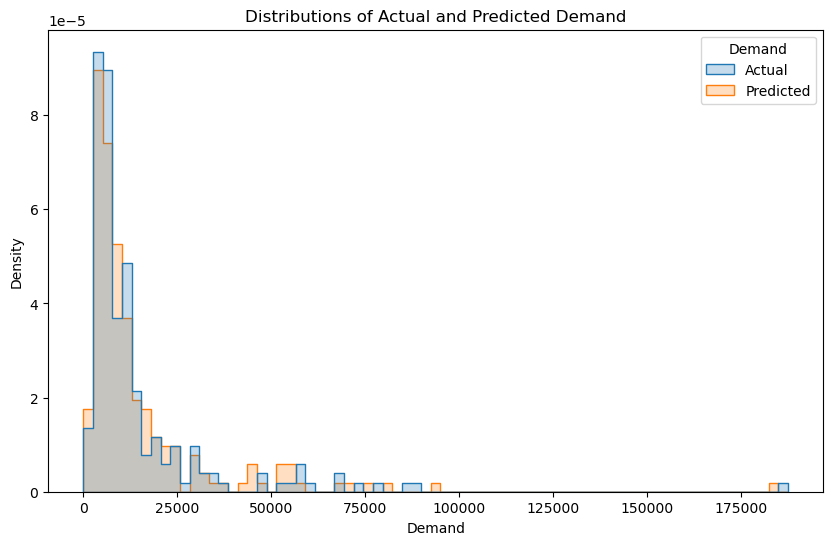

In [18]:
# Create a DataFrame for the actual and predicted values
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

# Melt the DataFrame to long-form so seaborn can plot two distributions on one chart
df_melt = df.melt(var_name='Demand', value_name='b')

# Plot the distributions of actual and predicted values
plt.figure(figsize=(10, 6))
sns.histplot(data=df_melt, x='b', hue='Demand', element='step', stat='density', common_norm=False)
plt.xlabel('Demand')
plt.title('Distributions of Actual and Predicted Demand')
plt.show()

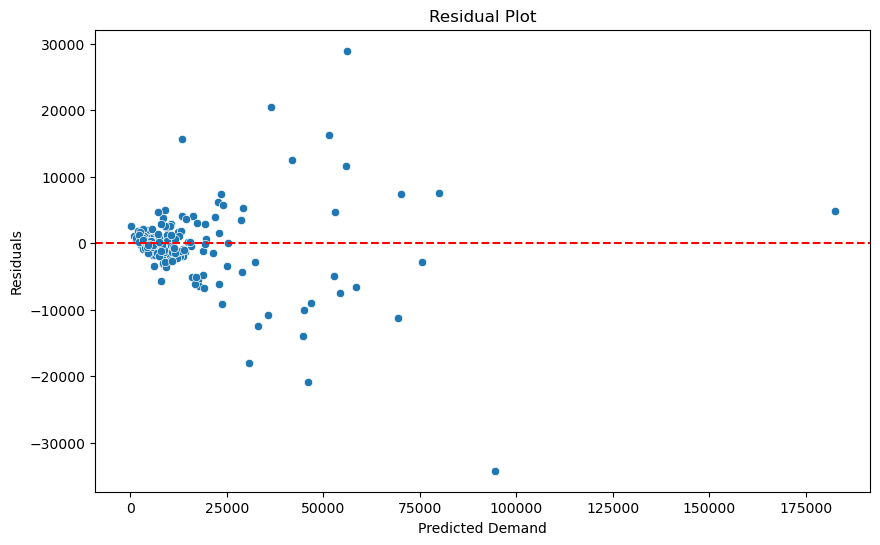

In [21]:
# Assuming y_test are your actual values and y_pred are your predicted values
residuals = y_test - y_pred

# Create a residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred.flatten(), y=residuals.flatten())
plt.xlabel('Predicted Demand')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')  # a horizontal line at y=0 for reference
plt.show()

In [22]:
# Convert numpy array to pandas DataFrame
y_test_df = pd.DataFrame(y_test)

# Use describe() method
y_test_df.describe()

,0
count,200.000000
mean,14529.845000
std,20127.274869
min,1961.000000
25%,4941.750000
50%,7741.000000
75%,13984.000000
max,187506.000000


In [23]:
# Convert numpy array to pandas DataFrame
y_pred_df = pd.DataFrame(y_pred)

# Use describe() method
y_pred_df.describe()

,0
count,200.000000
mean,14839.018142
std,19836.005664
min,59.970194
25%,4861.752236
50%,8308.542410
75%,15580.019181
max,182632.323904


In [35]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

# Define independent and target variables
independent_vars = ["sentiment_score","difficulty_level","difficulty_index","age","minplayers","maxplayers","minplaytime","maxplaytime","overall_rank","subdomain_rank","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","year_published","average_rating","bayes_average_rating","stddev","main_publisher","publisher_num","expansions_count","accessories_count"]
target_var = 'demand'

# Split the data into training, validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(top_game_complete[independent_vars], top_game_complete[target_var], test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Specify the categorical columns
cat_features = ["difficulty_level","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","main_publisher"]

# best results:
best_params= {'use_best_model': True, 'random_strength': 2, 'iterations': 8000, 'bagging_temperature': 0, 'l2_leaf_reg': 3, 
              'grow_policy': 'SymmetricTree', 'depth': 3, 'learning_rate': 0.05, 'border_count': 254}

# best_params = {'use_best_model': True, 
#                'border_count': 254, 
#                'bagging_temperature': 0, 
#                'depth': 4, 
#                'random_strength': 0, 
#                'iterations': 3000, 
#                'learning_rate': 0.2, 
#                'l2_leaf_reg': 0.5, 
#                'grow_policy': 'SymmetricTree',
#                'od_type': 'Iter',
#                'od_wait': 20
#                }


# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'learning_rate': [0.05, 0.15, 0.2],
#     'depth': [2, 4, 6],
#     'l2_leaf_reg': [0.5, 3],
#     'iterations': [1000, 3000],
#     'random_strength': [0, 2],
#     'border_count': [254],
#     'bagging_temperature': [0, 1],
#     'use_best_model': [True],
#     'grow_policy': ['SymmetricTree'],
#     # 'od_type': ['Iter', None],
#     # 'od_wait': [20],
# }

# # Initialize CatBoostRegressor
# model = CatBoostRegressor(loss_function='RMSE', verbose=False)

# # Perform grid search with early stopping
# grid_search_result = model.grid_search(param_grid,
#                                        X=Pool(X_train, y_train, cat_features=cat_features),
#                                        cv=5,
#                                        plot=False,
#                                        stratified=False,
#                                        partition_random_seed=42,
#                                        calc_cv_statistics=True,
#                                        search_by_train_test_split=True,
#                                        refit=False,
#                                        shuffle=True,
#                                        train_size=0.8,
#                                        verbose=True)

# # Get the best parameters
# best_params = grid_search_result['params']
# print(f'Best parameters: {best_params}')

# Train the model with the best parameters
model_og = CatBoostRegressor(**best_params, loss_function='RMSE', verbose=False)
model_og.fit(Pool(X_train, y_train, cat_features=cat_features), eval_set=Pool(X_val, y_val, cat_features=cat_features))

# Get predictions
y_pred = model_og.predict(X_test)
y_train_pred = model_og.predict(X_train)

# Evaluate the model
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f'Root Mean Squared Error on training: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_train, y_train_pred)
print(f'Mean Absolute Error on training: {mae}')

# Calculate R-squared
r2_train = r2_score(y_train, y_train_pred)
print(f'R-squared on training: {r2_train}')

n = len(y_test)  # number of samples
p = len(independent_vars)  # number of predictors

adjusted_r2_train = 1 - (1 - r2_train) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared on training: {adjusted_r2_train}')

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error on testing: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error on testing: {mae}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared on testing: {r2}')

# Calculate Adjusted R-squared
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared on testing: {adjusted_r2}')

Root Mean Squared Error on training: 1911.347468184565
Mean Absolute Error on training: 1183.3774769922668
R-squared on training: 0.9894949539466301
Adjusted R-squared on training: 0.9877029166787024
Root Mean Squared Error on testing: 5629.11039592173
Mean Absolute Error on testing: 3023.3386559766623
R-squared on testing: 0.9213884252878087
Adjusted R-squared on testing: 0.9079782154839644


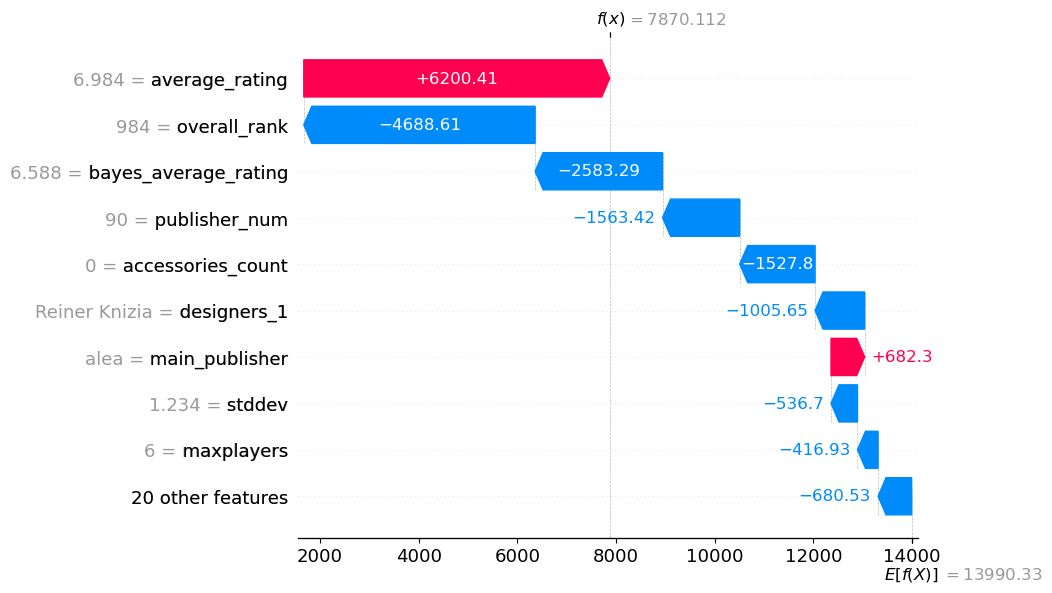

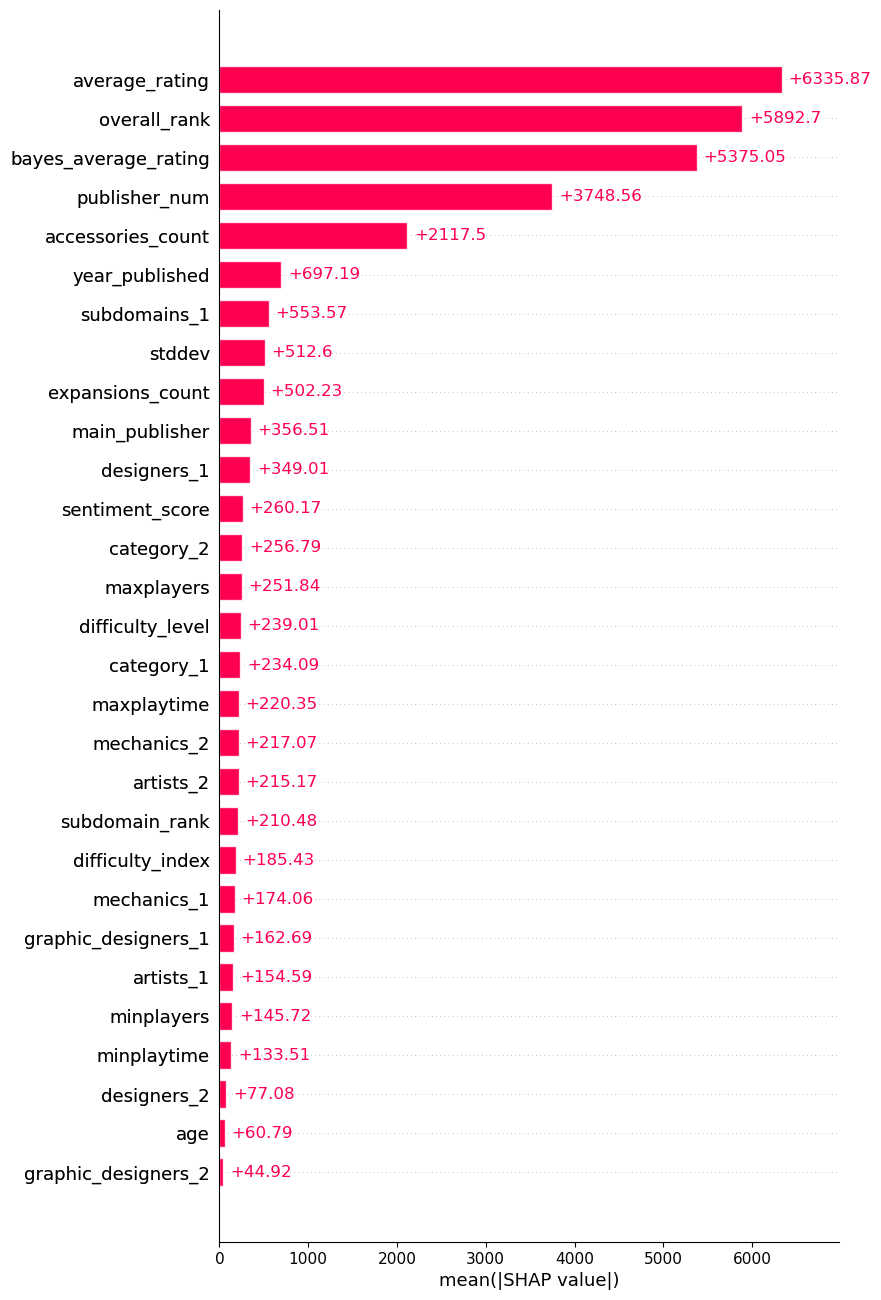

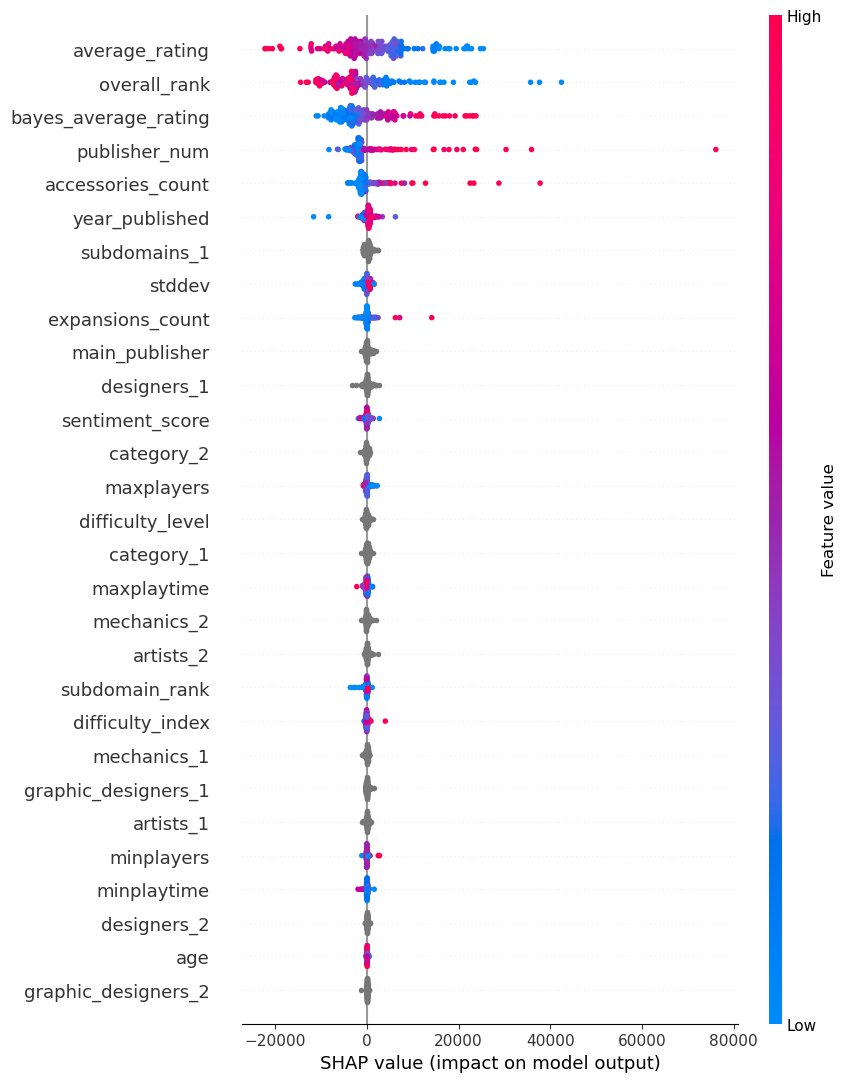

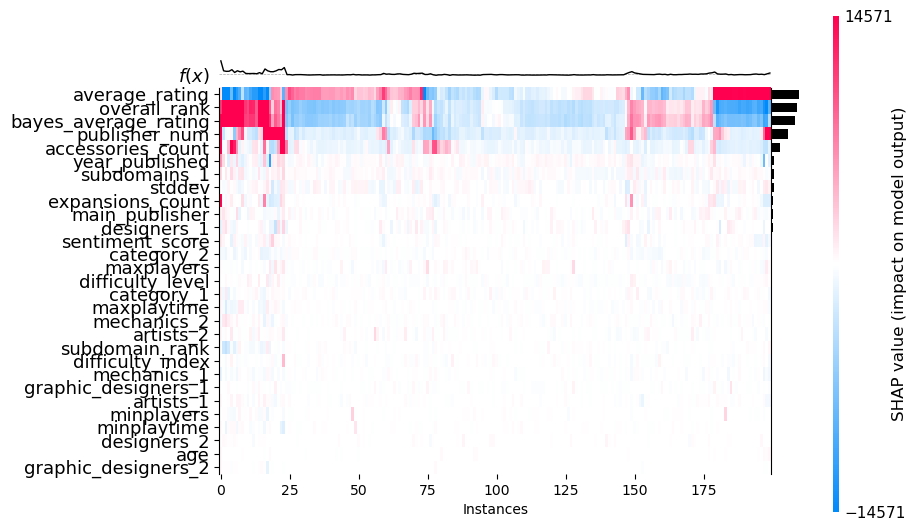

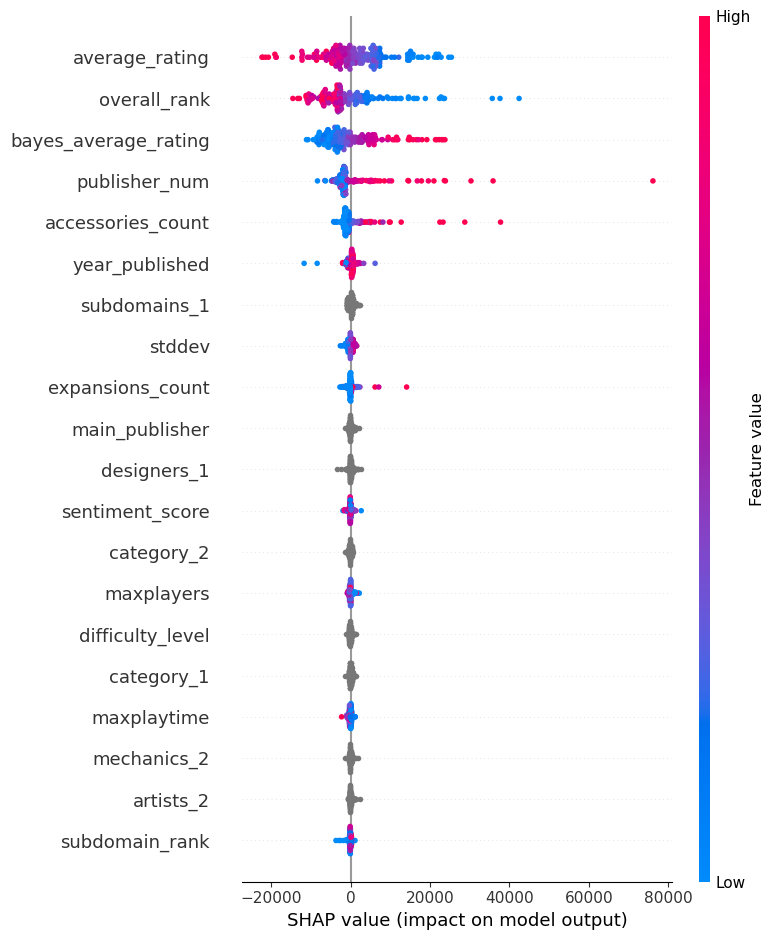

In [38]:
import shap

# Initialize the explainer
explainer = shap.Explainer(model_og)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Plot the SHAP values for a single prediction
shap.plots.waterfall(shap_values[0])
shap.plots.bar(shap_values, max_display=50)
shap.plots.beeswarm(shap_values, max_display=50)
shap.plots.heatmap(shap_values, max_display=50)

# Plot the summary of SHAP values for all features
shap.summary_plot(shap_values, X_test)

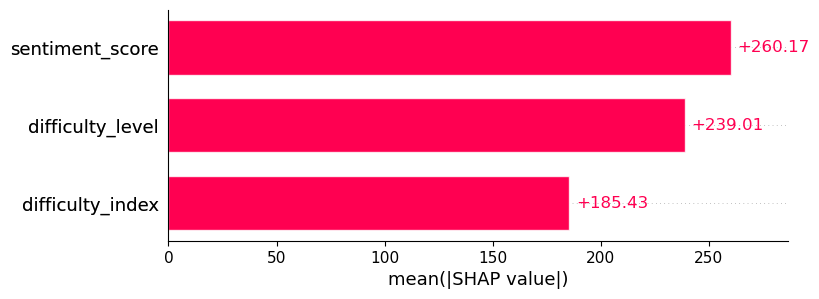

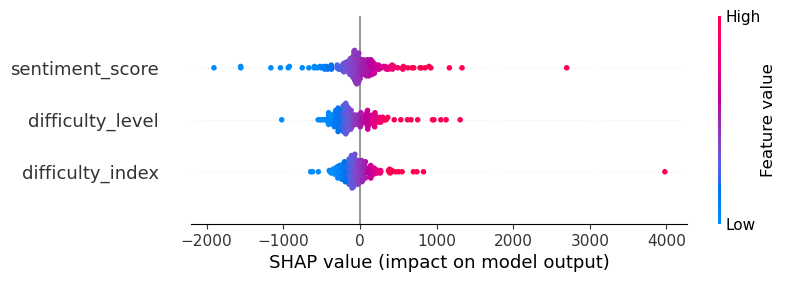

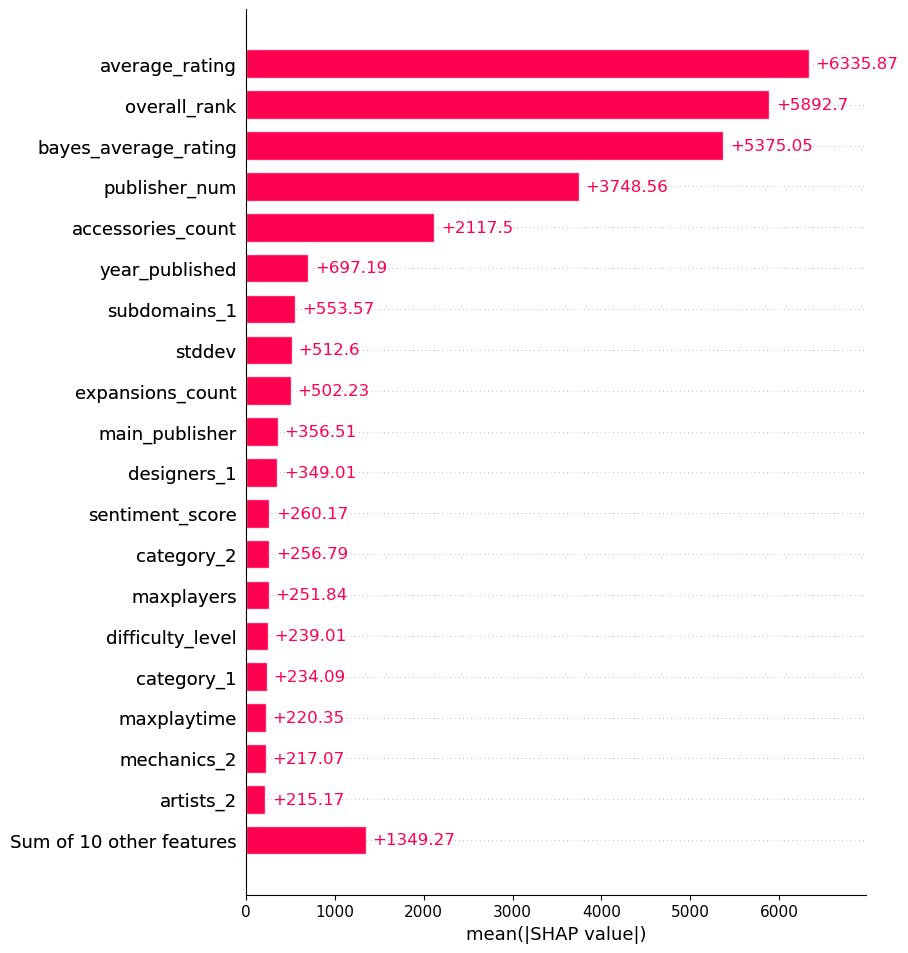

In [40]:
# List of attributes to keep
attributes = [
    "sentiment_score",
    "difficulty_level",
    "difficulty_index",
]
# Assuming `shap_values` is your calculated SHAP values
# Convert the SHAP values to a DataFrame for easier manipulation
shap_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)

# Filter the DataFrame to include only the features in your list
filtered_shap_df = shap_df[attributes]

# Convert the filtered DataFrame back to SHAP values
filtered_shap_values = shap.Explanation(values=filtered_shap_df.values, 
                                        base_values=shap_values.base_values, 
                                        data=filtered_shap_df, 
                                        feature_names=filtered_shap_df.columns.tolist())

shap.plots.bar(filtered_shap_values, max_display=20)
shap.plots.beeswarm(filtered_shap_values, max_display=20)
shap.plots.bar(shap_values, max_display=20)

2. $sentiment score$ + $difficulty level$: __0.8434802605106336__ 

In [26]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Read the top_game_enhanced2.csv
top_game_complete = pd.read_csv('top_game_complete.csv')

# Define independent and target variables
independent_vars = ["sentiment_score","difficulty_level","age","minplayers","maxplayers","minplaytime","maxplaytime","overall_rank","subdomain_rank","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","year_published","average_rating","bayes_average_rating","stddev","main_publisher","publisher_num","expansions_count","accessories_count"]
target_var = 'demand'

# Split the data into training, and test sets
X_train, X_test, y_train, y_test = train_test_split(top_game_complete[independent_vars], top_game_complete[target_var], test_size=0.2, random_state=42)

# Specify the categorical columns
cat_features = ["difficulty_level","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","main_publisher"]

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=5, learning_rate=0.05, loss_function='RMSE', verbose=False)

# Fit model
train_pool = Pool(X_train, y_train, cat_features=cat_features)
model.fit(train_pool)

# Get predictions
test_pool = Pool(X_test, cat_features=cat_features)
y_pred = model.predict(test_pool)

# Evaluate the model
rmse = sqrt(mean_squared_error(y_test, y_pred, squared=False))
print(f'Root Mean Squared Error: {rmse}')
from sklearn.metrics import r2_score

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Calculate Adjusted R-squared
n = len(y_test)  # number of samples
p = len(independent_vars)  # number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared: {adjusted_r2}')

Root Mean Squared Error: 88.47313211609652
Mean Absolute Error: 3419.7486842894346
R-squared: 0.8544641018783085
Adjusted R-squared: 0.8434802605106336


c:\Users\17366\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3. $sentiment score$ + $difficulty index$: __0.8384306422074363__ 

In [14]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Read the top_game_enhanced2.csv
top_game_complete = pd.read_csv('top_game_complete.csv')

# Define independent and target variables
independent_vars = ["sentiment_score","difficulty_index","age","minplayers","maxplayers","minplaytime","maxplaytime","overall_rank","subdomain_rank","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","year_published","average_rating","bayes_average_rating","stddev","main_publisher","publisher_num","expansions_count","accessories_count"]
target_var = 'demand'

# Split the data into training, and test sets
X_train, X_test, y_train, y_test = train_test_split(top_game_complete[independent_vars], top_game_complete[target_var], test_size=0.2, random_state=42)

# Specify the categorical columns
cat_features = ["mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","main_publisher"]

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=5, learning_rate=0.05, loss_function='RMSE', verbose=False)

# Fit model
train_pool = Pool(X_train, y_train, cat_features=cat_features)
model.fit(train_pool)

# Get predictions
test_pool = Pool(X_test, cat_features=cat_features)
y_pred = model.predict(test_pool)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Calculate Adjusted R-squared
n = len(y_test)  # number of samples
p = len(independent_vars)  # number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared: {adjusted_r2}')

Root Mean Squared Error: 7952.757610855455
R-squared: 0.8497688427542829
Adjusted R-squared: 0.8384306422074363


c:\Users\17366\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Hyperparameter Tuning

Normalized

In [27]:
import pandas as pd
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define independent and target variables
independent_vars = ["sentiment_score","age","minplayers","maxplayers","minplaytime","maxplaytime","overall_rank","subdomain_rank","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","year_published","average_rating","bayes_average_rating","stddev","main_publisher","publisher_num","expansions_count","accessories_count"]
target_var = 'demand_normalized'

# Split the data into training, validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(top_game_complete[independent_vars], top_game_complete[target_var], test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Specify the categorical columns
cat_features = ["mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","main_publisher"]

best_params= {'use_best_model': True, 'random_strength': 2, 'iterations': 2000, 'bagging_temperature': 0, 'l2_leaf_reg': 0.5, 
              'grow_policy': 'SymmetricTree', 'depth': 2, 'learning_rate': 0.1, 'border_count': 254}

# best_params = {'use_best_model': True, 
#              'border_count': 254, 
#              'bagging_temperature': 0, 
#              'depth': 6, 
#              'random_strength': 0, 
#             #  'od_wait': 20, 
#              'iterations': 1000, 
#              'learning_rate': 0.15, 
#              'l2_leaf_reg': 0.5, 
#              'grow_policy': 'SymmetricTree', 
#             #  'od_type': 'Iter'
#              }


# Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'learning_rate': [0.05, 0.1, 0.15, 0.2],
#     'depth': [2, 4, 6, 8],
#     'l2_leaf_reg': [0.5, 3],
#     'iterations': [1000, 3000],
#     'random_strength': [0, 2],
#     'border_count': [254],
#     'bagging_temperature': [0, 1],
#     'use_best_model': [True],
#     'grow_policy': ['SymmetricTree'],
#     'od_type': ['Iter', None],
#     'od_wait': [20],
# }

# # Initialize CatBoostRegressor
# model = CatBoostRegressor(loss_function='RMSE', verbose=False)

# # Perform grid search with early stopping
# grid_search_result = model.grid_search(param_grid,
#                                        X=Pool(X_train, y_train, cat_features=cat_features),
#                                        cv=5,
#                                        plot=False,
#                                        stratified=False,
#                                        partition_random_seed=42,
#                                        calc_cv_statistics=True,
#                                        search_by_train_test_split=True,
#                                        refit=False,
#                                        shuffle=True,
#                                        train_size=0.8,
#                                        verbose=True)

# # Get the best parameters
# best_params = grid_search_result['params']
# print(f'Best parameters: {best_params}')

# Train the model with the best parameters
model = CatBoostRegressor(**best_params, loss_function='RMSE', verbose=False)
model.fit(Pool(X_train, y_train, cat_features=cat_features), eval_set=Pool(X_val, y_val, cat_features=cat_features))

# Get predictions
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Evaluate the model
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f'Root Mean Squared Error on training: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_train, y_train_pred)
print(f'Mean Absolute Error on training: {mae}')

# Calculate R-squared
r2_train = r2_score(y_train, y_train_pred)
print(f'R-squared on training: {r2_train}')

n = len(y_test)  # number of samples
p = len(independent_vars)  # number of predictors

adjusted_r2_train = 1 - (1 - r2_train) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared on training: {adjusted_r2_train}')

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error on testing: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error on testing: {mae}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared on testing: {r2}')

# Calculate Adjusted R-squared
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared on testing: {adjusted_r2}')

Root Mean Squared Error on training: 0.015344428780282884
Mean Absolute Error on training: 0.00940748754991677
R-squared on training: 0.9735520640056836
Adjusted R-squared on training: 0.9694003531228549
Root Mean Squared Error on testing: 0.03146470667298256
Mean Absolute Error on testing: 0.01720622358604771
R-squared on testing: 0.904054192333116
Adjusted R-squared on testing: 0.8889929318272679


In [96]:
# Convert numpy array to pandas DataFrame
y_test_df = pd.DataFrame(y_test)

# Use describe() method
y_test_df.describe()

,demand_normalized
count,200.000000
mean,0.068162
std,0.101835
min,0.004569
25%,0.019650
50%,0.033813
75%,0.065400
max,0.943348


In [97]:
# Convert numpy array to pandas DataFrame
y_pred_df = pd.DataFrame(y_pred)

# Use describe() method
y_pred_df.describe()

,0
count,200.000000
mean,0.069726
std,0.100362
min,-0.005050
25%,0.019245
50%,0.036685
75%,0.073475
max,0.918689


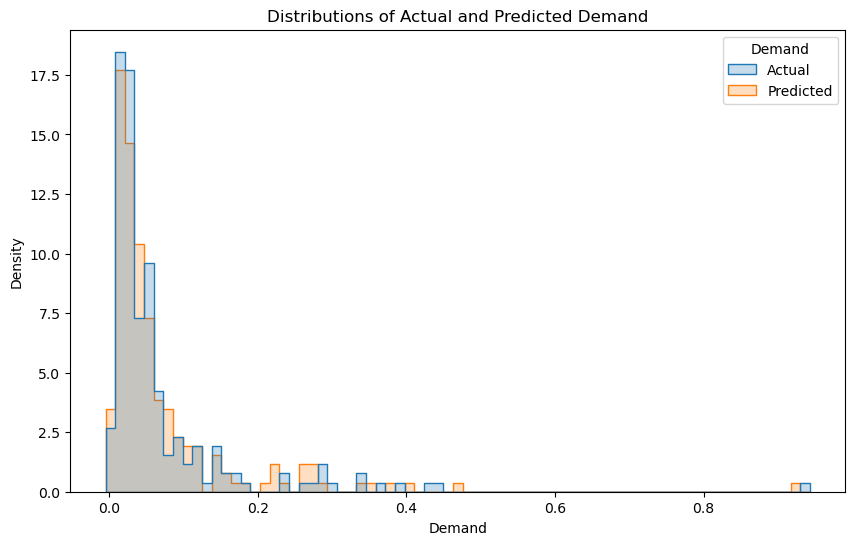

In [98]:
# Create a DataFrame for the actual and predicted values
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Melt the DataFrame to long-form so seaborn can plot two distributions on one chart
df_melt = df.melt(var_name='Demand', value_name='b')

# Plot the distributions of actual and predicted values
plt.figure(figsize=(10, 6))
sns.histplot(data=df_melt, x='b', hue='Demand', element='step', stat='density', common_norm=False)
plt.xlabel('Demand')
plt.title('Distributions of Actual and Predicted Demand')
plt.show()


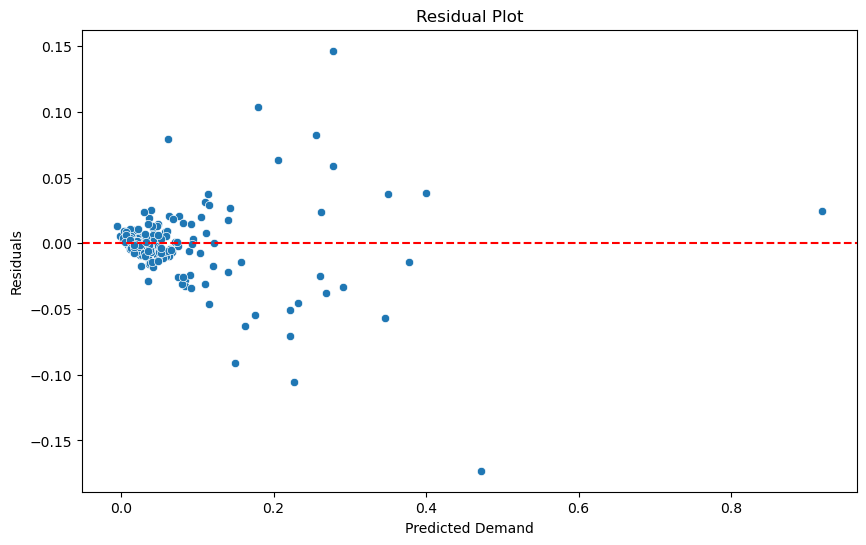

In [99]:
# Assuming y_test are your actual values and y_pred are your predicted values
residuals = y_test - y_pred

# Create a residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.xlabel('Predicted Demand')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')  # a horizontal line at y=0 for reference
plt.show()

Original

In [49]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

# Define independent and target variables
independent_vars = ["sentiment_score","age","minplayers","maxplayers","minplaytime","maxplaytime","overall_rank","subdomain_rank","mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","year_published","average_rating","bayes_average_rating","stddev","main_publisher","publisher_num","expansions_count","accessories_count"]
target_var = 'demand'

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(top_game_complete[independent_vars], top_game_complete[target_var], test_size=0.2, random_state=42)

# Specify the categorical columns
cat_features = ["mechanics_1","mechanics_2","category_1","category_2","subdomains_1","artists_1","artists_2","designers_1","designers_2","graphic_designers_1","graphic_designers_2","main_publisher"]

# Define the parameter grid
# param_grid = {
#     'learning_rate': [0.03, 0.06, 0.1, 0.13, 0.16, 0.19, 0.22, 0.25, 0.28, 0.31, 0.34, 0.37, 0.4, 0.43, 0.46, 0.49],
#     'depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
#     'l2_leaf_reg': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25],
#     'iterations': [200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000],
#     'border_count': [128, 254, 512, 1024],
#     'bagging_temperature': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#     'use_best_model': [True],
#     'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    
# }

best_params= {'use_best_model': False, 'random_strength': 2, 'iterations': 2000, 'bagging_temperature': 0, 'l2_leaf_reg': 0.5, 
              'grow_policy': 'SymmetricTree', 'depth': 2, 'learning_rate': 0.1, 'border_count': 254}

# Initialize CatBoostRegressor
# model = CatBoostRegressor(task_type="GPU", loss_function='RMSE', verbose=False)

# Convert categorical features to integer codes
# for feature in cat_features:
#     X_train[feature] = X_train[feature].astype('category').cat.codes
#     X_test[feature] = X_test[feature].astype('category').cat.codes

# # Perform grid search
# grid_search_result = model.grid_search(param_grid, X=X_train, y=y_train, cv=10, plot=False)

# # Get the best parameters
# best_params = grid_search_result['params']
# print(f'Best parameters: {best_params}')

# Train the model with the best parameters
model = CatBoostRegressor(loss_function='RMSE', verbose=False, **best_params, cat_features=cat_features)
model.fit(X_train, y_train)

# Get predictions
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Evaluate the model
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f'Root Mean Squared Error on training: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_train, y_train_pred)
print(f'Mean Absolute Error on training: {mae}')

# Calculate R-squared
r2_train = r2_score(y_train, y_train_pred)
print(f'R-squared on training: {r2_train}')

n = len(y_test)  # number of samples
p = len(independent_vars)  # number of predictors

adjusted_r2_train = 1 - (1 - r2_train) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared on training: {adjusted_r2_train}')

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error on testing: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error on testing: {mae}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared on testing: {r2}')

# Calculate Adjusted R-squared
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared on testing: {adjusted_r2}')

Root Mean Squared Error on training: 2892.573785773997
Mean Absolute Error on training: 1852.5488041386025
R-squared on training: 0.9734863233977442
Adjusted R-squared on training: 0.9715619436443547
Root Mean Squared Error on testing: 7128.775761034152
Mean Absolute Error on testing: 3499.550887634016
R-squared on testing: 0.8792868928607886
Adjusted R-squared on testing: 0.8705254576652007


In [50]:
# Convert numpy array to pandas DataFrame
y_test_df = pd.DataFrame(y_test)

# Use describe() method
y_test_df.describe()

,demand
count,400.000000
mean,14401.515000
std,20543.824078
min,1785.000000
25%,4981.750000
50%,7551.000000
75%,14416.000000
max,195224.000000


In [51]:
# Convert numpy array to pandas DataFrame
y_pred_df = pd.DataFrame(y_pred)

# Use describe() method
y_pred_df.describe()

,0
count,400.000000
mean,14535.780874
std,19084.605154
min,-522.346780
25%,5380.250058
50%,8158.913992
75%,15262.191362
max,165308.486047


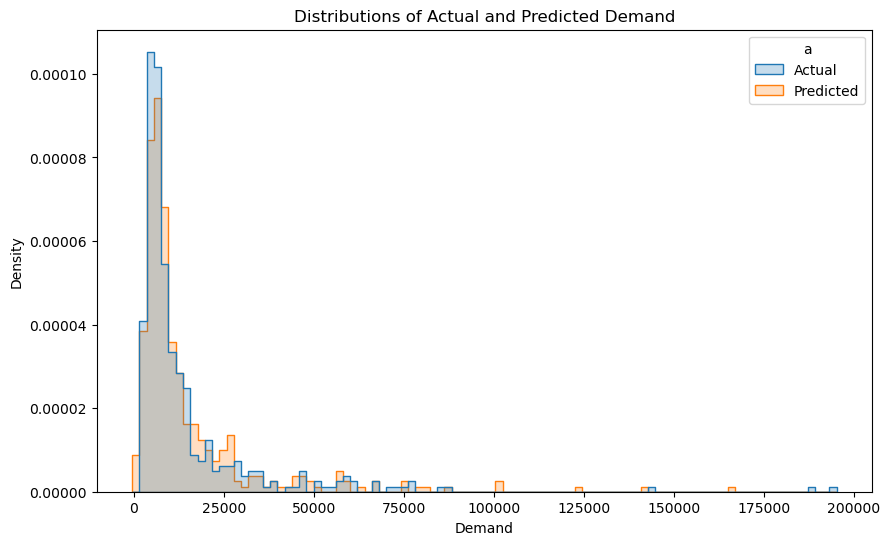

In [40]:
# Create a DataFrame for the actual and predicted values
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Melt the DataFrame to long-form so seaborn can plot two distributions on one chart
df_melt = df.melt(var_name='a', value_name='b')

# Plot the distributions of actual and predicted values
plt.figure(figsize=(10, 6))
sns.histplot(data=df_melt, x='b', hue='a', element='step', stat='density', common_norm=False)
plt.xlabel('Demand')
plt.title('Distributions of Actual and Predicted Demand')
plt.show()